In [ ]:
import os
import shap
import pickle
import itertools
import numpy                as np
import pandas               as pd
import seaborn              as sns
import tensorflow           as tf
import matplotlib.pyplot    as plt
from scipy.stats            import iqr


from labels                 import class_labels
plt.rcParams['text.usetex'] = True

Matplotlib created a temporary cache directory at /JOBs/tmpdir/pbs.9670356.spcc-adm1/matplotlib-toc4b0uz because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2024-11-05 19:13:31.387232: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 19:13:31.390150: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 19:13:31.426077: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has alrea

In [2]:
def organize_by_class(expl_data, class_labels, model_names):
    return {
        class_name: [expl_data[class_name][model_name] for model_name in model_names] for class_name in class_labels
    }

def remove_outliers(scores):
    if len(scores) < 2:
        return scores
    scores_array = np.array(scores)
    q1, q3       = np.percentile(scores_array, [25, 75])
    iqr_value    = iqr(scores_array)
    lower_bound  = q1 - 1.5 * iqr_value
    upper_bound  = q3 + 1.5 * iqr_value
    
    return [score for score in scores_array if lower_bound <= score <= upper_bound]

In [3]:
def compute_cosine_distance_lime(mask1, mask2):
    if mask1.dtype != np.float32:
        mask1       = np.array(mask1).astype('float32')
    if mask2.dtype != np.float32:
        mask2       = np.array(mask2).astype('float32')

    mask1_flat      = mask1.flatten()
    mask2_flat      = mask2.flatten()

    dot_product     = np.dot(mask1_flat, mask2_flat)
    magnitude1      = np.linalg.norm(mask1_flat)
    magnitude2      = np.linalg.norm(mask2_flat)

    if magnitude1 == 0 or magnitude2 == 0:
        return 1.0
        # raise ValueError("One of both of the input masks have zero magnitude, causing division by zero.")
        
    similarity      = dot_product / (magnitude1 * magnitude2)
    cosine_distance = 1 - similarity

    return cosine_distance

def compute_mean_distance_lime(expl_list, model_names):
    pairwise_codistance  = {}
    
    for (i, expl_list1), (j, expl_list2) in itertools.combinations(enumerate(expl_list), 2):
        cosine_distances = []
    
        for expl1, expl2 in zip(expl_list1, expl_list2):
            distance     = compute_cosine_distance_lime(expl1, expl2) # >>>>>
            cosine_distances.append(distance)

        cleaned_distance = remove_outliers(cosine_distances)
        mean_distance    = np.mean(cleaned_distance)
        
        model_pair       = (model_names[i], model_names[j])
        pairwise_codistance[model_pair] = mean_distance

    return pairwise_codistance

In [4]:
def apply_threshold_and_binarize(shap_values, percentile=0.2):

    shap_values_squeezed      = shap_values.squeeze()
    shap_values_float         = shap_values_squeezed.astype('float32')

    binarized_values          = np.zeros_like(shap_values_float)

    for channel in range(shap_values_float.shape[2]):  # Iterate through RGB channels
        shap_values_channel   = shap_values_float[:, :, channel]
        positive_shap_values  = shap_values_channel[shap_values_channel > 0]

        if positive_shap_values.size > 0:
            max_score        = np.max(positive_shap_values)
            threshold        = percentile * max_score
        else:
            max_score        = 0
            threshold        = 0
            print(f'No positive SHAP values found in channel {channel}')
        
        # print(f'Max Positive SHAP Score for Channel {channel} : {max_score:.4f}')
        # print(f'Threshold Value for Channel {channel}         : {threshold:.4f}')

        binarized_values[:, :, channel] = np.where(shap_values_channel >= threshold, 1, 0).astype('float32')

    grayscale_image = np.mean(binarized_values, axis=2) 

    return grayscale_image

def compute_cosine_distance_shap(mask1, mask2):
    mask1_values    = mask1[0].values
    mask2_values    = mask2[0].values

    mask1_binarized = apply_threshold_and_binarize(mask1_values)
    mask2_binarized = apply_threshold_and_binarize(mask2_values)
    
    mask1_flat      = mask1_binarized.flatten()
    mask2_flat      = mask2_binarized.flatten()

    dot_product     = np.dot(mask1_flat, mask2_flat)
    magnitude1      = np.linalg.norm(mask1_flat)
    magnitude2      = np.linalg.norm(mask2_flat)
    
    similarity      = dot_product / (magnitude1 * magnitude2)
    cosine_distance = 1 - similarity
    
    return cosine_distance

def compute_mean_distance_shap(expl_list, model_names):
    pairwise_codistance   = {}
    
    for (i, expl_list1), (j, expl_list2) in itertools.combinations(enumerate(expl_list), 2):
        cosine_distances  = []
     
        for expl1, expl2 in zip(expl_list1, expl_list2):
            cosine_dist   = compute_cosine_distance_shap(expl1, expl2)
            cosine_distances.append(cosine_dist)

        cleaned_distance  = remove_outliers(cosine_distances)
        mean_distance     = np.mean(cleaned_distance)
        
        model_pair        = (model_names[i], model_names[j])
        pairwise_codistance[model_pair] = mean_distance

    return pairwise_codistance

In [5]:
# Plot class wise results in box-plot format
def plot_class_wise_cosine_distances(class_labels, model_names, class_wise_cosine, title):
    plt.figure(figsize=(20, 16))
    
    for i, class_name in enumerate(class_labels):
        # Prepare data for boxplot
        data = {
            f'{model_i} vs {model_j}': class_wise_cosine[class_name][(model_i, model_j)]
            for (model_i, model_j) in itertools.combinations(model_names, 2)
        }
        
        df = pd.DataFrame(data)

        # Create subplot for each class
        plt.subplot(3, 4, i + 1)
        sns.boxplot(data = df, palette = 'Set2')
        plt.xlabel('Model Pair', fontsize  = 14)
        plt.xticks(rotation = 45, fontsize = 12)
        plt.ylabel('Cosine Distance Score', fontsize = 14)
        plt.yticks(fontsize=12)
        plt.title(f'{title}: {class_name}', fontsize = 14)
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
# Plot overall cosine distance across classes, with highlighting average score
def plot_mean_cosine_distance_across_classes(distance_dict_mask, classes, title, show_legend = True):
    model_pairs       = list(distance_dict_mask[classes[0]].keys())
    model_pair_labels = [f"{pair[0]} vs {pair[1]}" for pair in model_pairs]
    
    average_score_by_class = [
        np.mean([distance_dict_mask[class_name][pair] for pair in model_pairs])
        for class_name in classes
    ]

    plt.figure(figsize=(12, 8))
    for pair in model_pairs:
        mean_distances = [distance_dict_mask[class_name][pair] for class_name in classes]
        plt.plot(classes, mean_distances, marker='o', label = f'Model Pair: {pair[0]} vs {pair[1]}', alpha=0.3)

    plt.plot(classes, average_score_by_class, marker ='o', color = 'black', label = 'Average Across All Model Pairs', linewidth=3)
    plt.xlabel('Classes', fontsize     = 20)
    plt.ylabel('Mean Cosine Distance', fontsize=20)
    plt.title(f'{title}', fontsize     = 20)
    plt.xticks(rotation = 45, fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.ylim(0.0, )

    if show_legend:
        plt.legend()
        
    plt.grid(True)
    plt.show()

In [ ]:
# Different Feature Extractors

In [6]:
class_names  = class_labels
model_extrcs = ["Xception", "InceptionV3", "DenseNet121", "ResNet50V2"]

In [7]:
temp_extrcs  = {class_name: {} for class_name in class_names}
mask_extrcs  = {class_name: {} for class_name in class_names}

for class_idx, class_name in enumerate(class_names):
    for model_name in model_extrcs:
        file_path = f'LIME expls/diff_extrcs/explain_{class_names[class_idx]}_{model_name}.pkl'

        with open(file_path, 'rb') as file:
            temp_extrc, mask_extrc, _ = pickle.load(file)

        temp_extrcs[class_name][model_name] = temp_extrc
        mask_extrcs[class_name][model_name] = mask_extrc

In [8]:
print(len(temp_extrcs["tench"]["Xception"]))
print(len(mask_extrcs["tench"]["Xception"]))

50
50


float32
(224, 224, 3)


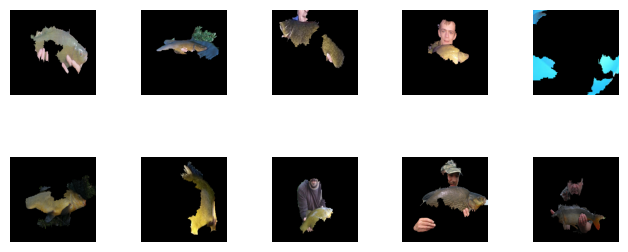

In [12]:
plt.figure()
for i, mask in enumerate(temp_extrcs["tench"]["Xception"][:10]):
    mask = np.array(mask.astype('float32'))
    plt.subplot(2,5, i +1)
    plt.imshow(mask)
    plt.tight_layout()
    plt.axis('off')

print(mask.dtype)
print(mask.shape)

(224, 224, 3)


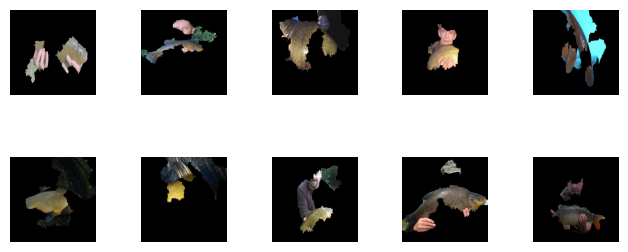

In [13]:
plt.figure()
for i, mask in enumerate(temp_extrcs["tench"]["InceptionV3"][:10]):
    plt.subplot(2,5, i +1)
    plt.imshow(mask)
    plt.tight_layout()
    plt.axis('off')

print(mask.shape)

In [9]:
# organize by class
lime_by_class_extrcs           = organize_by_class(mask_extrcs, class_names, model_extrcs)

class_wise_cosine_lime_extrcs  = {class_name: {pair: [] for pair in itertools.combinations(model_extrcs, 2)} for class_name in class_names}

for class_name in class_names:
    img_masks         = [mask_extrcs[class_name][model_name] for model_name in model_extrcs]
    
    for img_mask in zip(*img_masks):
        for (model_i, model_j) in itertools.combinations(model_extrcs, 2):
            mask_i        = img_mask[model_extrcs.index(model_i)]
            mask_j        = img_mask[model_extrcs.index(model_j)]

            if np.linalg.norm(mask_i) == 0 or np.linalg.norm(mask_j) == 0:
                print(f'Empty mask found between {model_i} and {model_j} for classs {class_name}')
                
            co_distance   = compute_cosine_distance_lime(mask_i, mask_j) 
            class_wise_cosine_lime_extrcs[class_name][(model_i, model_j)].append(co_distance) 
            

distance_dict_lime_extrcs = {}
for name in class_names:
    distance_dict_lime_extrcs[name] = compute_mean_distance_lime(expl_list   = lime_by_class_extrcs[name],
                                                                 model_names = model_extrcs)

Empty mask found between Xception and InceptionV3 for classs golf ball
Empty mask found between Xception and DenseNet121 for classs golf ball
Empty mask found between Xception and ResNet50V2 for classs golf ball


(224, 224, 3)


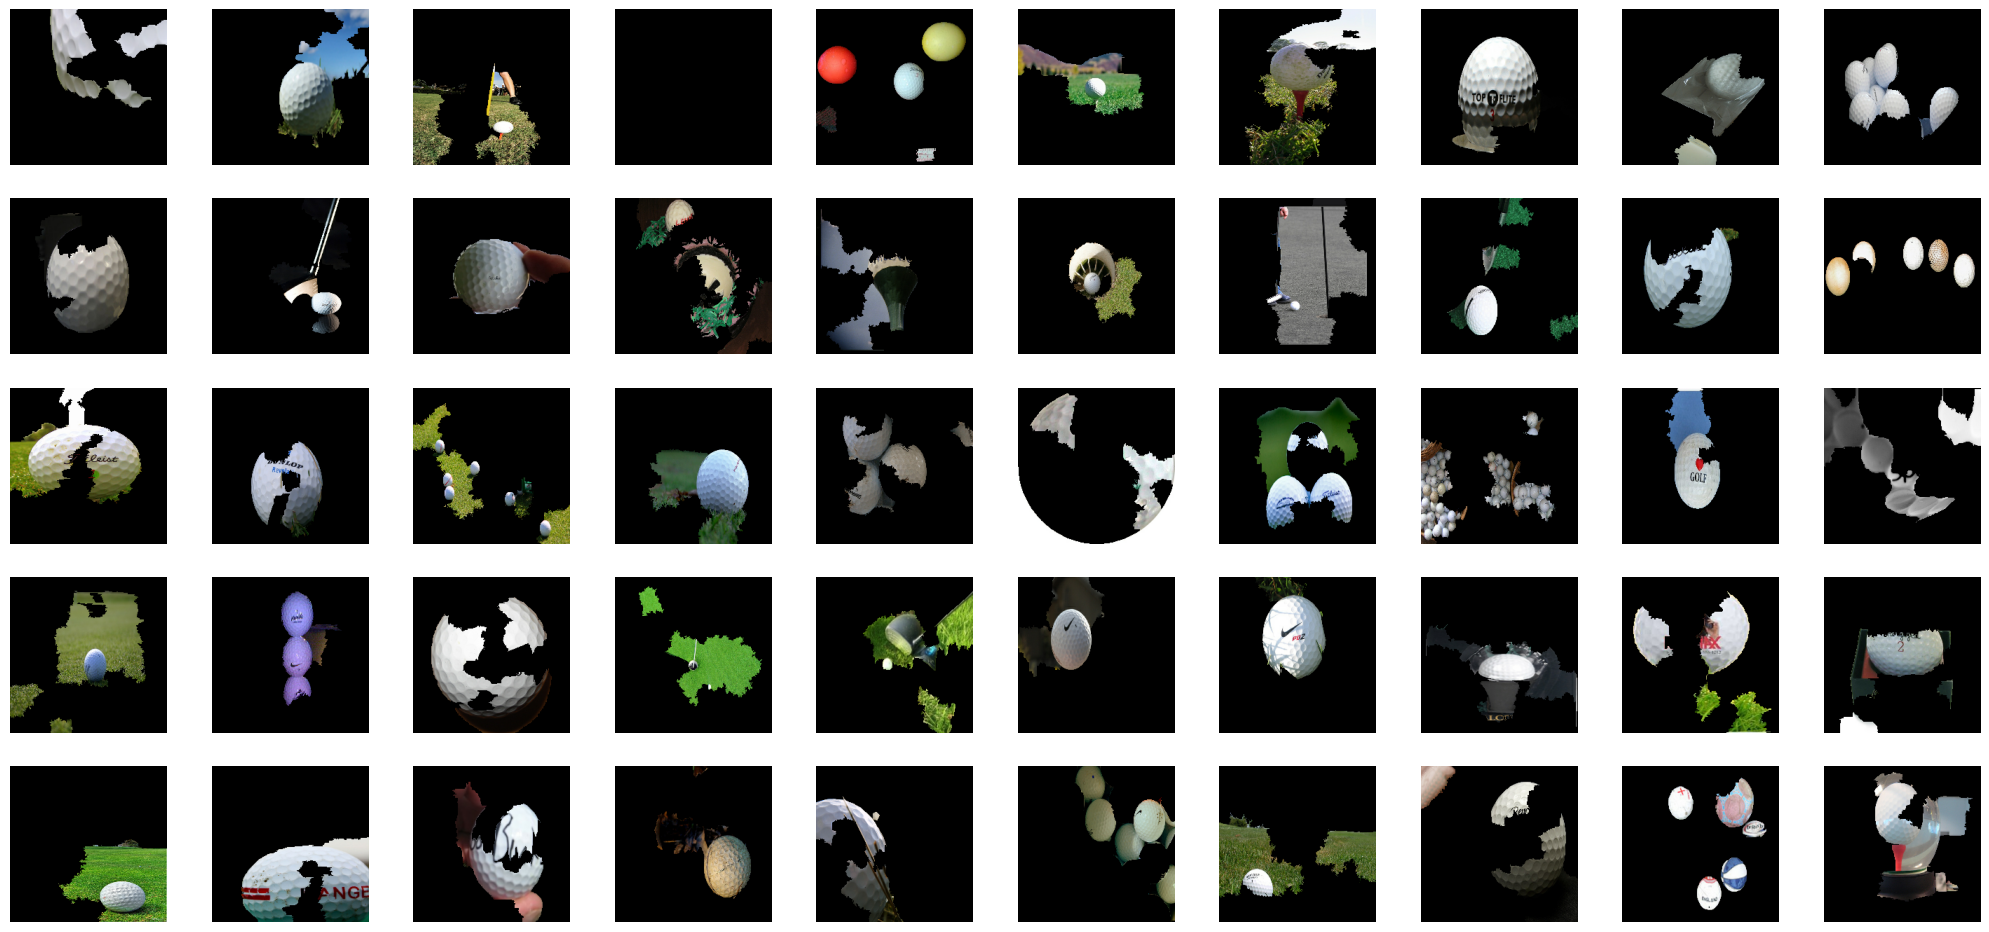

In [15]:
plt.figure(figsize=(20,10))
for i, mask in enumerate(temp_extrcs["golf ball"]["Xception"]):
    plt.subplot(5,10, i +1)
    plt.imshow(mask)
    plt.tight_layout()
    plt.axis('off')

print(mask.shape)

(224, 224)


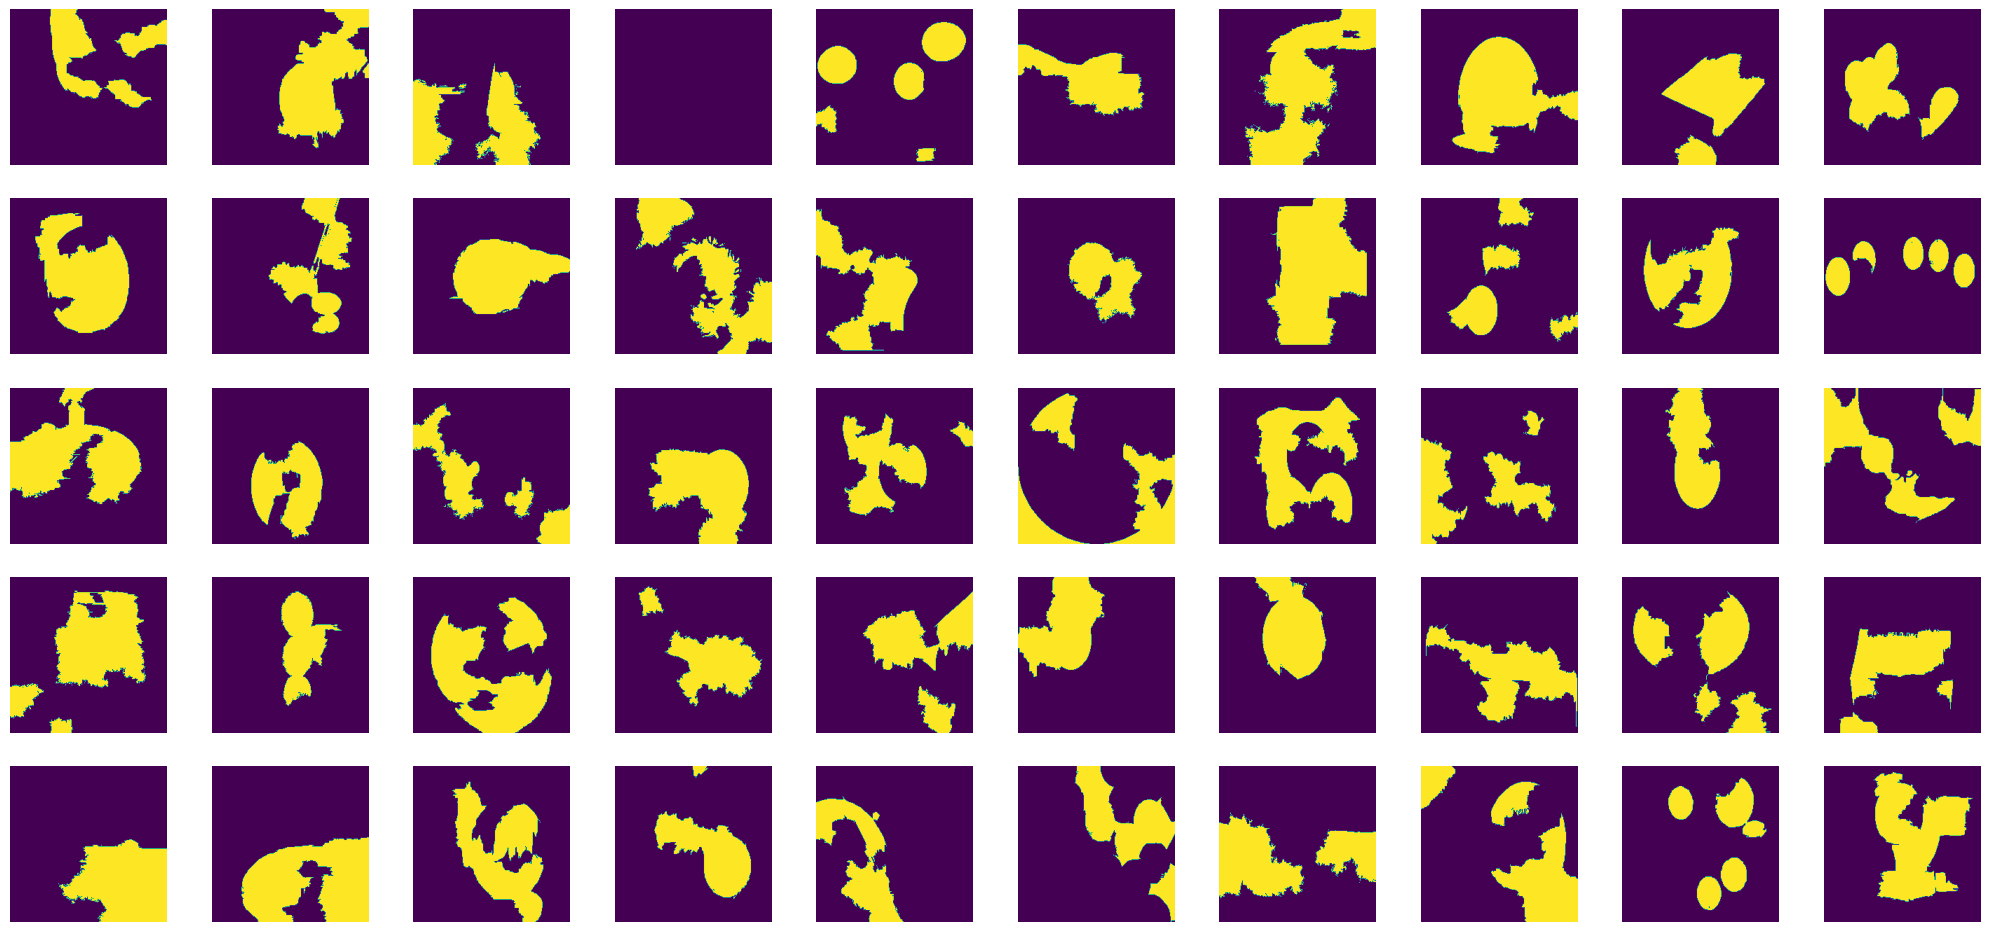

In [16]:
plt.figure(figsize=(20,10))
for i, mask in enumerate(mask_extrcs["golf ball"]["Xception"]):
    plt.subplot(5,10, i +1)
    plt.imshow(mask)
    plt.tight_layout()
    plt.axis('off')

print(mask.shape)

(224, 224, 3)


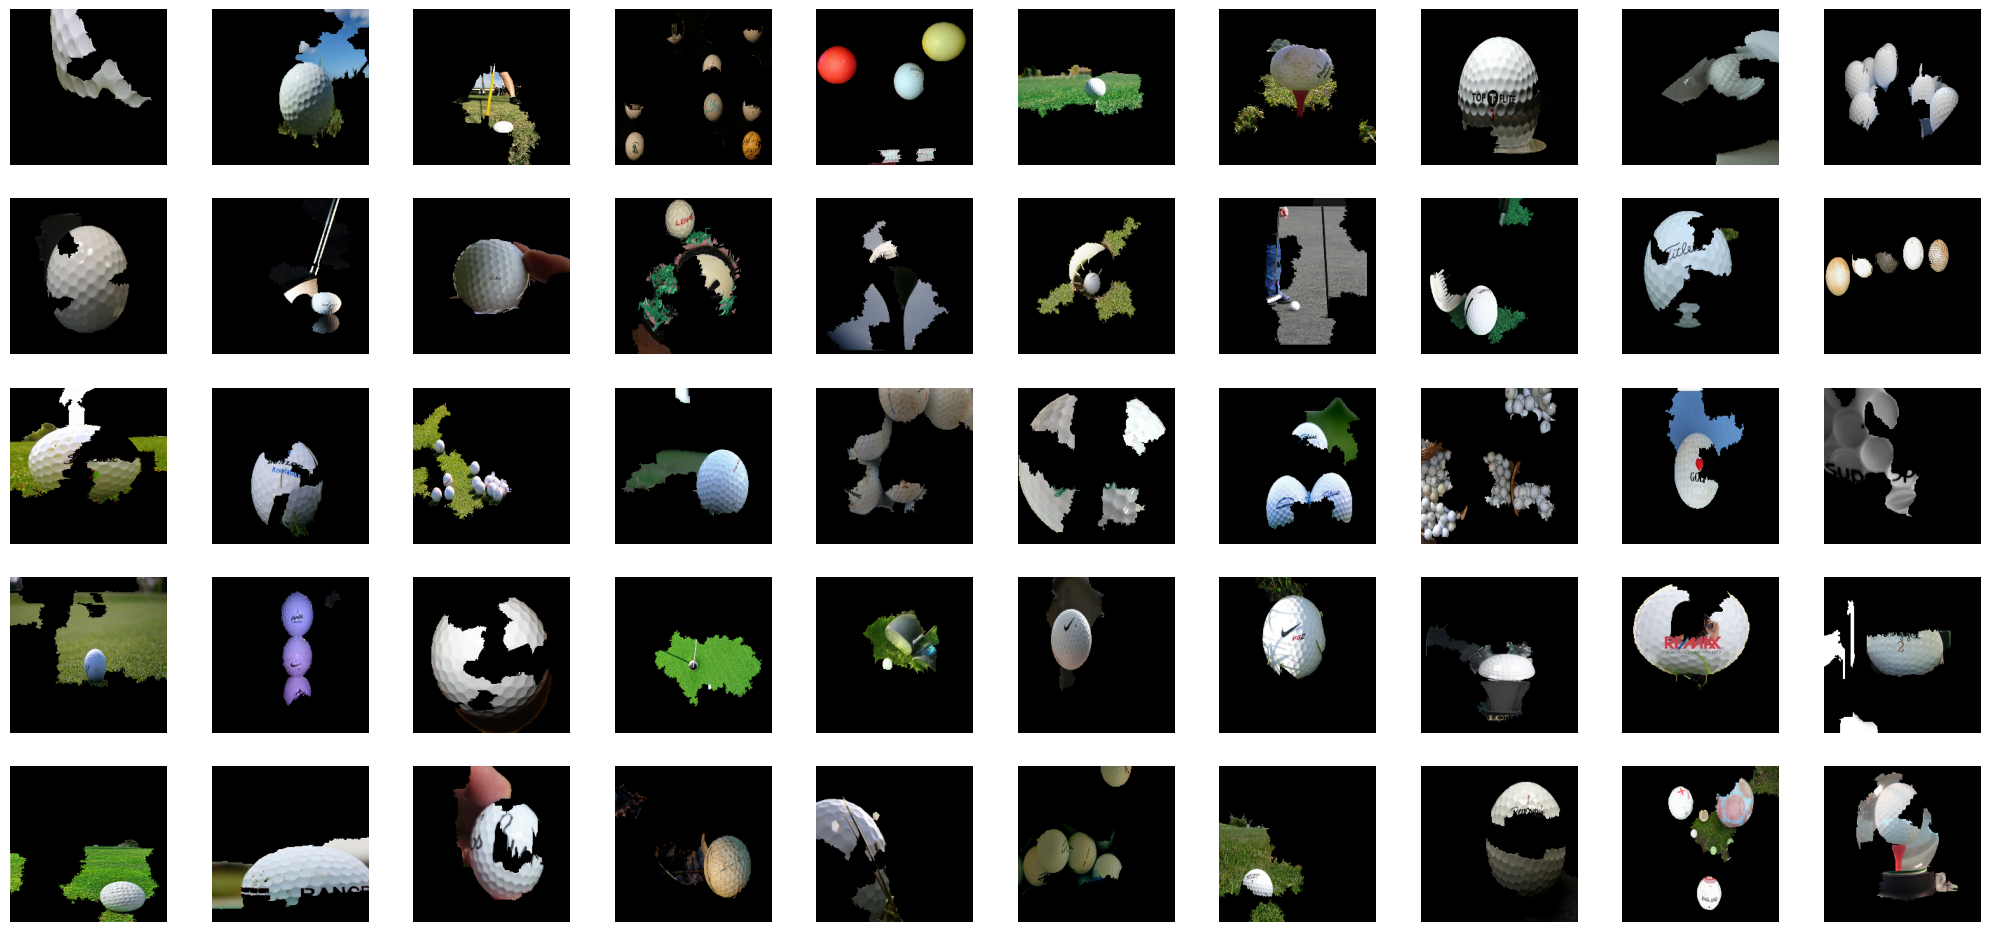

In [17]:
plt.figure(figsize=(20,10))
for i, mask in enumerate(temp_extrcs["golf ball"]["InceptionV3"]):
    plt.subplot(5,10, i +1)
    plt.imshow(mask)
    plt.tight_layout()
    plt.axis('off')

print(mask.shape)

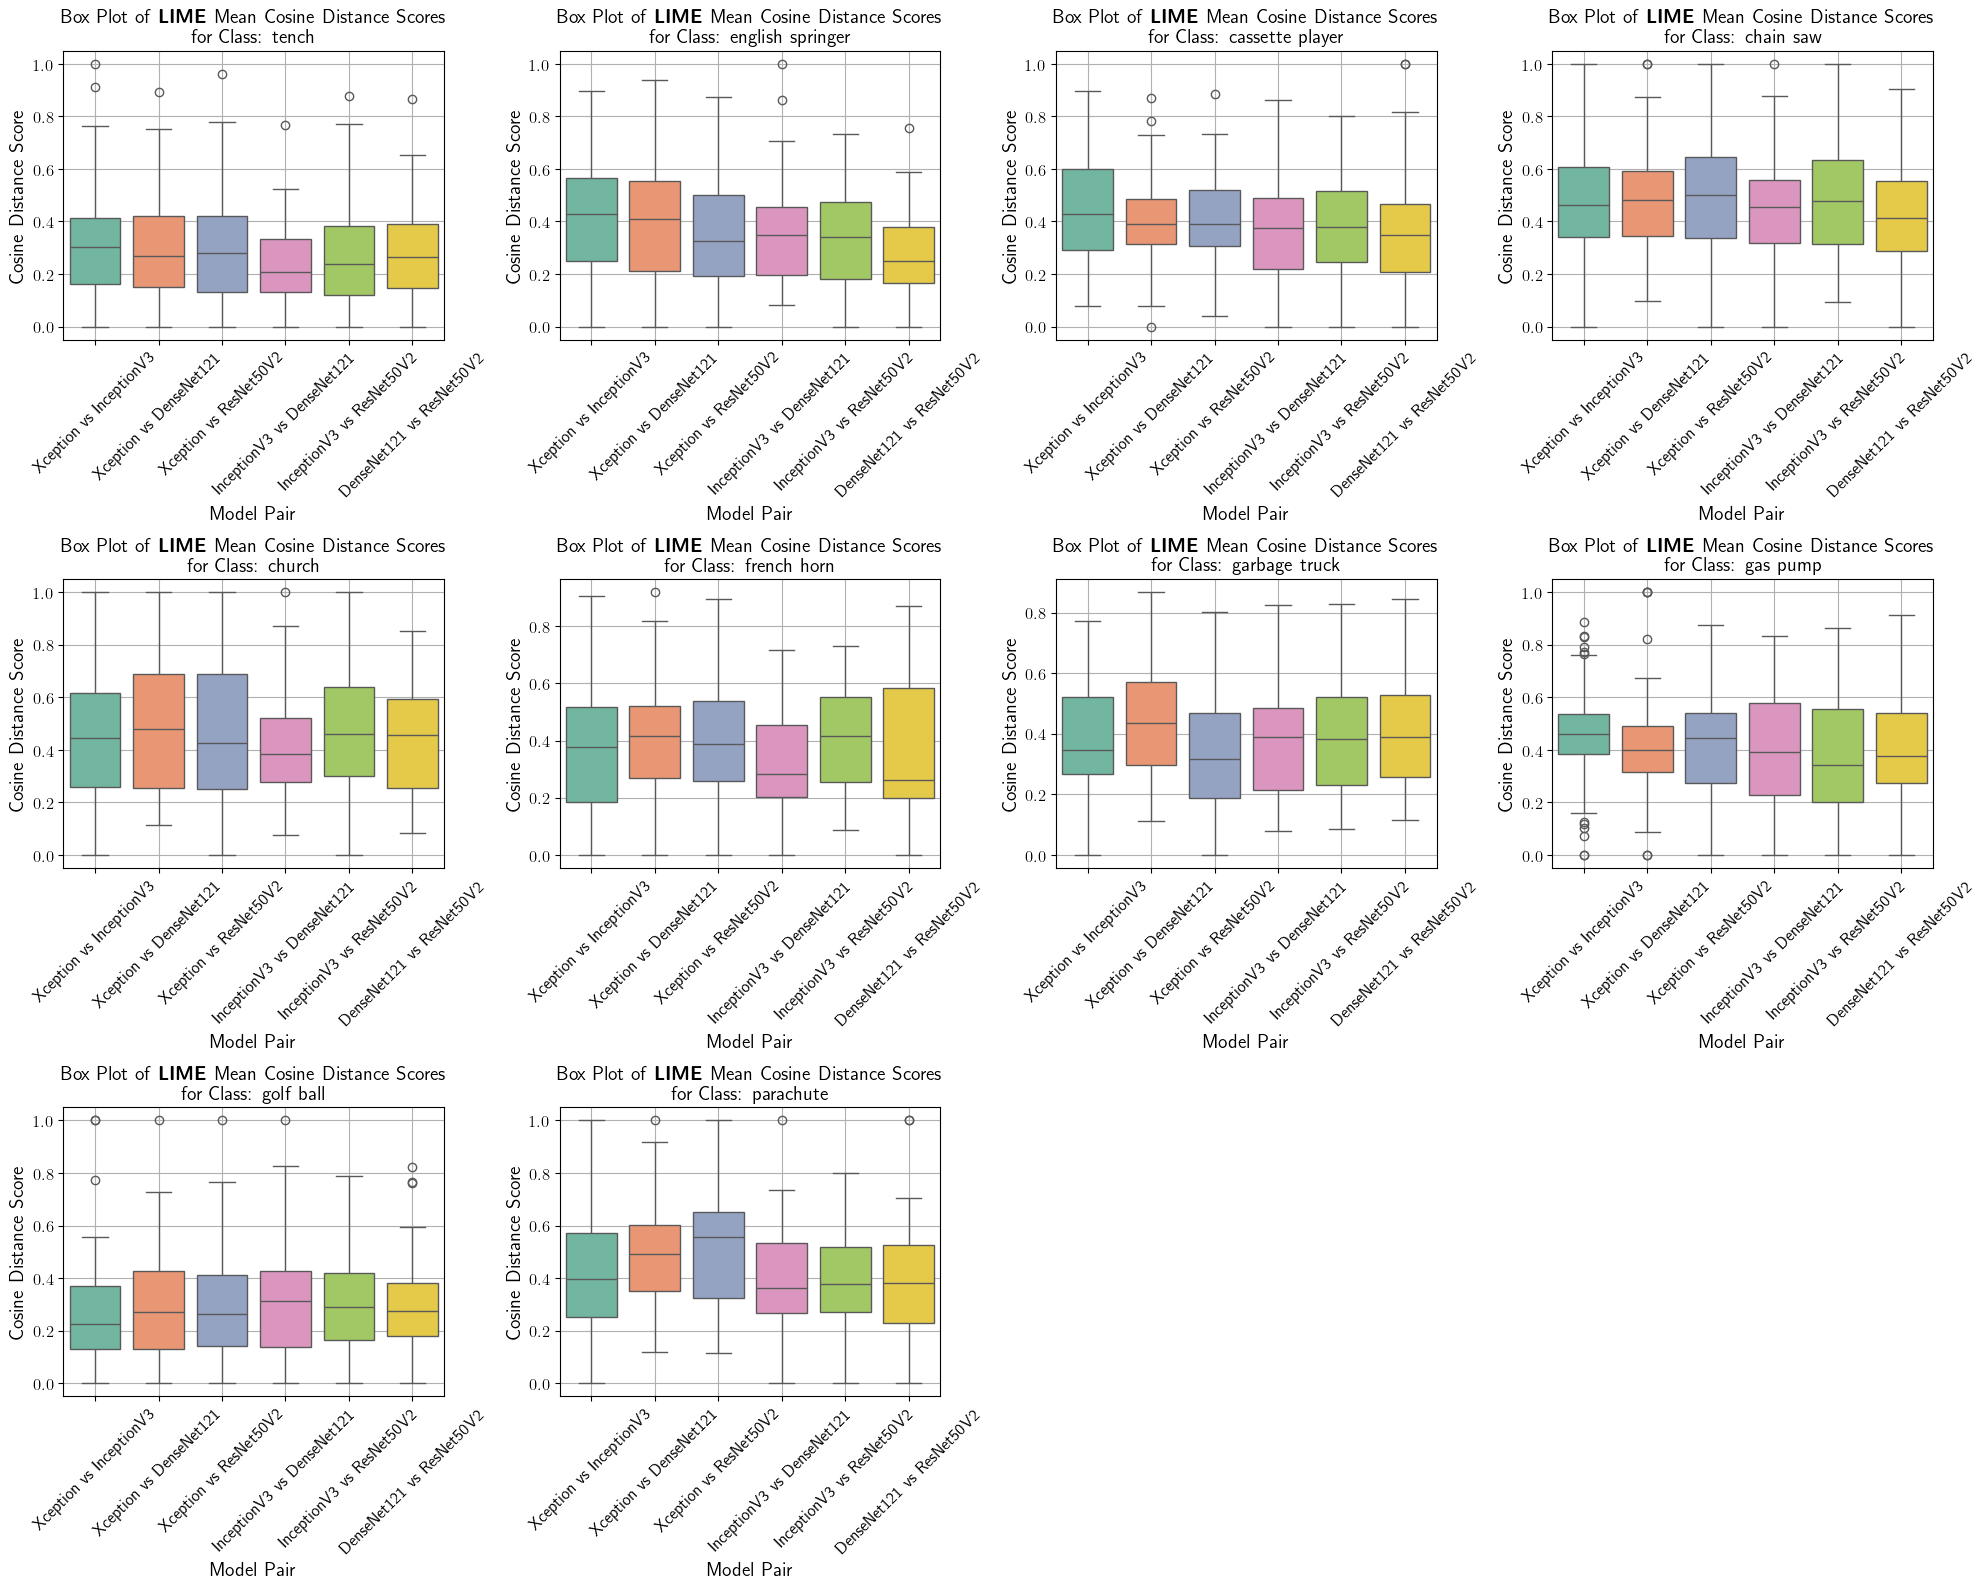

In [10]:
title = 'Box Plot of \\textbf{LIME} Mean Cosine Distance Scores\nfor Class'
plot_class_wise_cosine_distances(class_names, model_extrcs, class_wise_cosine_lime_extrcs, title)

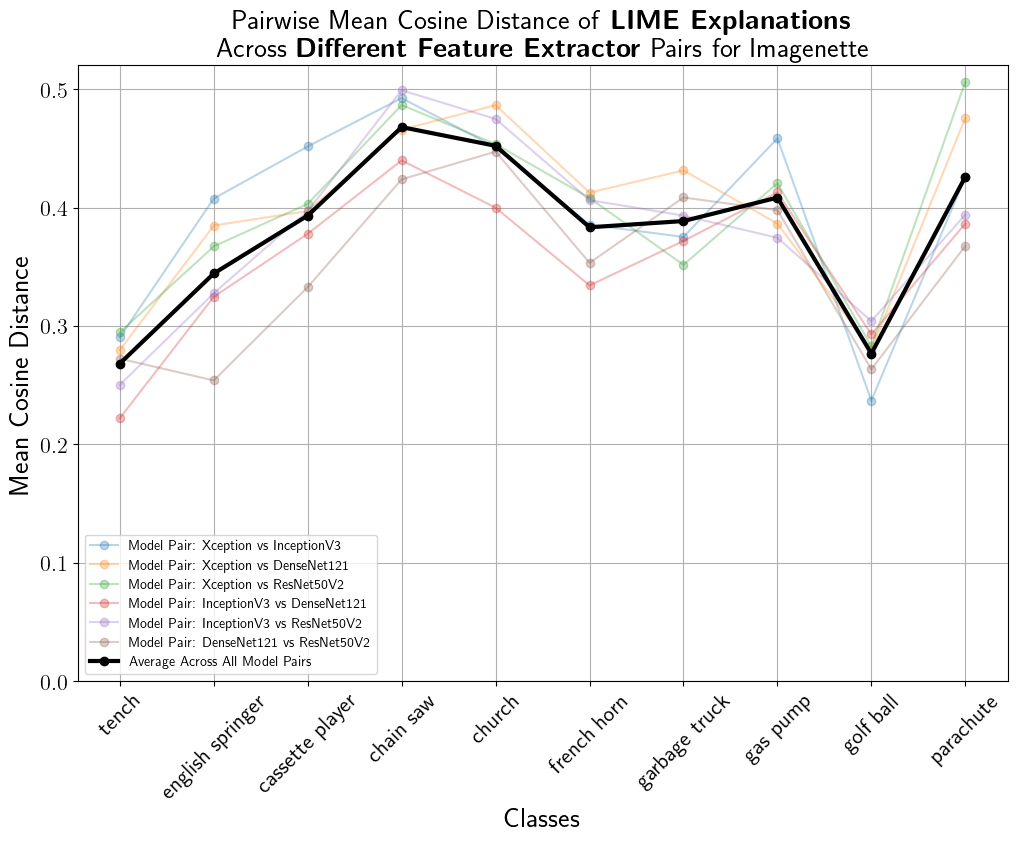

In [21]:
title = 'Pairwise Mean Cosine Distance of \\textbf{LIME Explanations}\nAcross \\textbf{Different Feature Extractor} Pairs for Imagenette'
plot_mean_cosine_distance_across_classes(distance_dict_lime_extrcs, class_names, title)

In [11]:
# SHAP

In [194]:
def visualize_binarized_shap(shap_values):
    print(f"Original SHAP Image Shape             : {shap_values.values[0].shape}")
    binarized_image = apply_threshold_and_binarize(shap_values.values[0])

    print(f"Shape after binarization              : {binarized_image.shape}, dtype : {binarized_image.dtype}")
    print(f"Min pixel value : {np.min(binarized_image)}, Max pixel value: {np.max(binarized_image)}")

    plt.imshow(binarized_image, cmap='gray') 
    plt.colorbar(label="Binarized SHAP Values (0 or 1)")
    plt.title("Binarized SHAP Image")
    plt.axis("off")
    plt.show()


def plot_score_distribution(shap_data, model_name):
    flattened = shap_data.flatten()

    # Plot the distribution using a histogram
    plt.hist(flattened, bins = 50, alpha = 0.7, color = 'blue')
    plt.title(f'Score Distribution for {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [11]:
shap_data_extrcs  = {class_name: {} for class_name in class_labels}

for class_idx, class_name in enumerate(class_labels):
    for i, model_name in enumerate(model_extrcs):
        file_path = f'SHAP expls/diff_extrcs/explain_{class_names[class_idx]}_model{i+1}_shap.pkl'
        
        with open(file_path, 'rb') as file:
            data  = pickle.load(file)

        shap_data_extrcs[class_name][model_name] = data

In [30]:
print(len(shap_data_extrcs["tench"]["Xception"]))

50


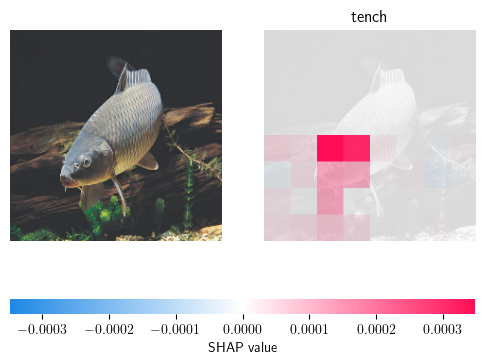

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


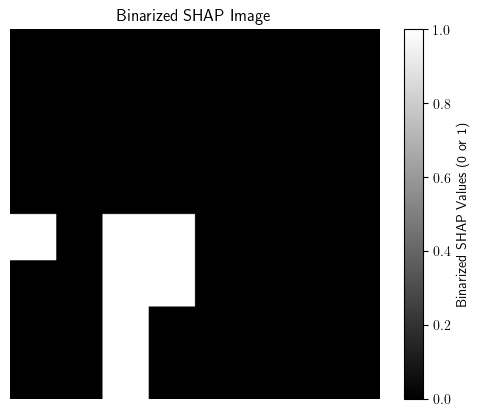

In [86]:
shap1 = shap_data_extrcs["tench"]["Xception"][0]
shap.image_plot(shap1)
visualize_binarized_shap(shap1)

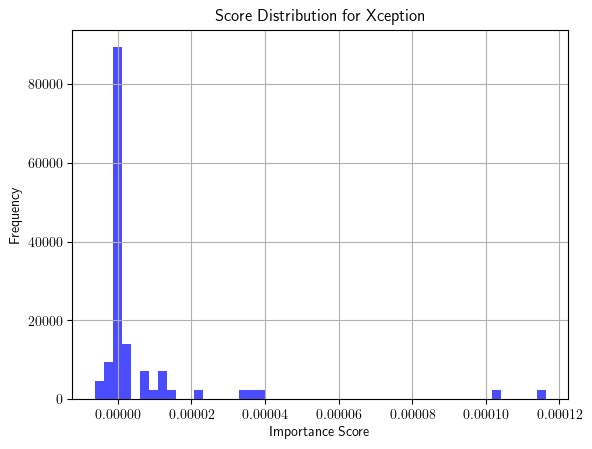

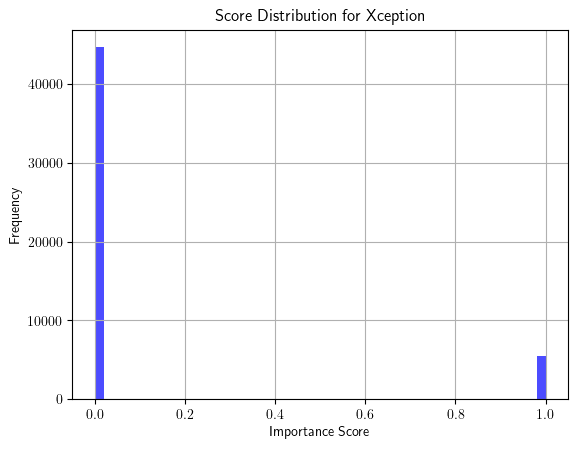

In [94]:
plot_score_distribution(shap1.values, "Xception")
shap1_binarized = apply_threshold_and_binarize(shap1.values[0])
plot_score_distribution(shap1_binarized, "Xception")

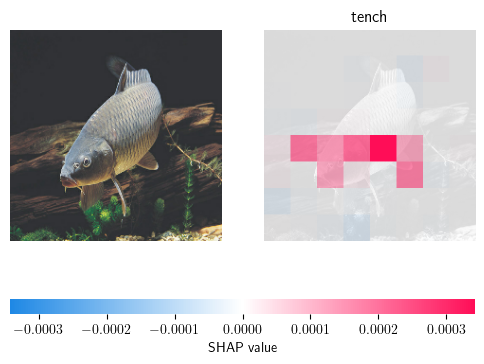

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


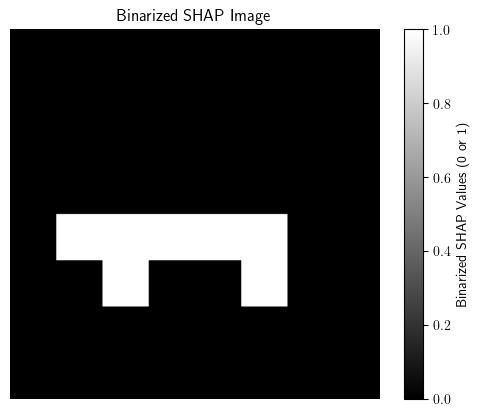

In [87]:
shap2 = shap_data_extrcs["tench"]["InceptionV3"][0]
shap.image_plot(shap2)
visualize_binarized_shap(shap2)

In [12]:
shap_by_class_extrcs          = organize_by_class(shap_data_extrcs, class_names, model_extrcs)

class_wise_cosine_shap_extrcs = {class_name: {pair: [] for pair in itertools.combinations(model_extrcs, 2)} for class_name in class_names}

for class_name in class_labels:
    shap_values = [shap_data_extrcs[class_name][model_name] for model_name in model_extrcs] 
    
    for shap_value in zip(*shap_values):  # Pair the masks for each model for the same image
        for (model_i, model_j) in itertools.combinations(model_extrcs, 2):
            mask_i        = shap_value[model_extrcs.index(model_i)]
            mask_j        = shap_value[model_extrcs.index(model_j)]
            co_distance   = compute_cosine_distance_shap(mask_i, mask_j) 
            class_wise_cosine_shap_extrcs[class_name][(model_i, model_j)].append(co_distance) 

distance_dict_shap_extrcs = {}

for name in class_labels:
    distance_dict_shap_extrcs[name]= compute_mean_distance_shap(expl_list = shap_by_class_extrcs[name], 
                                                              model_names = model_extrcs)

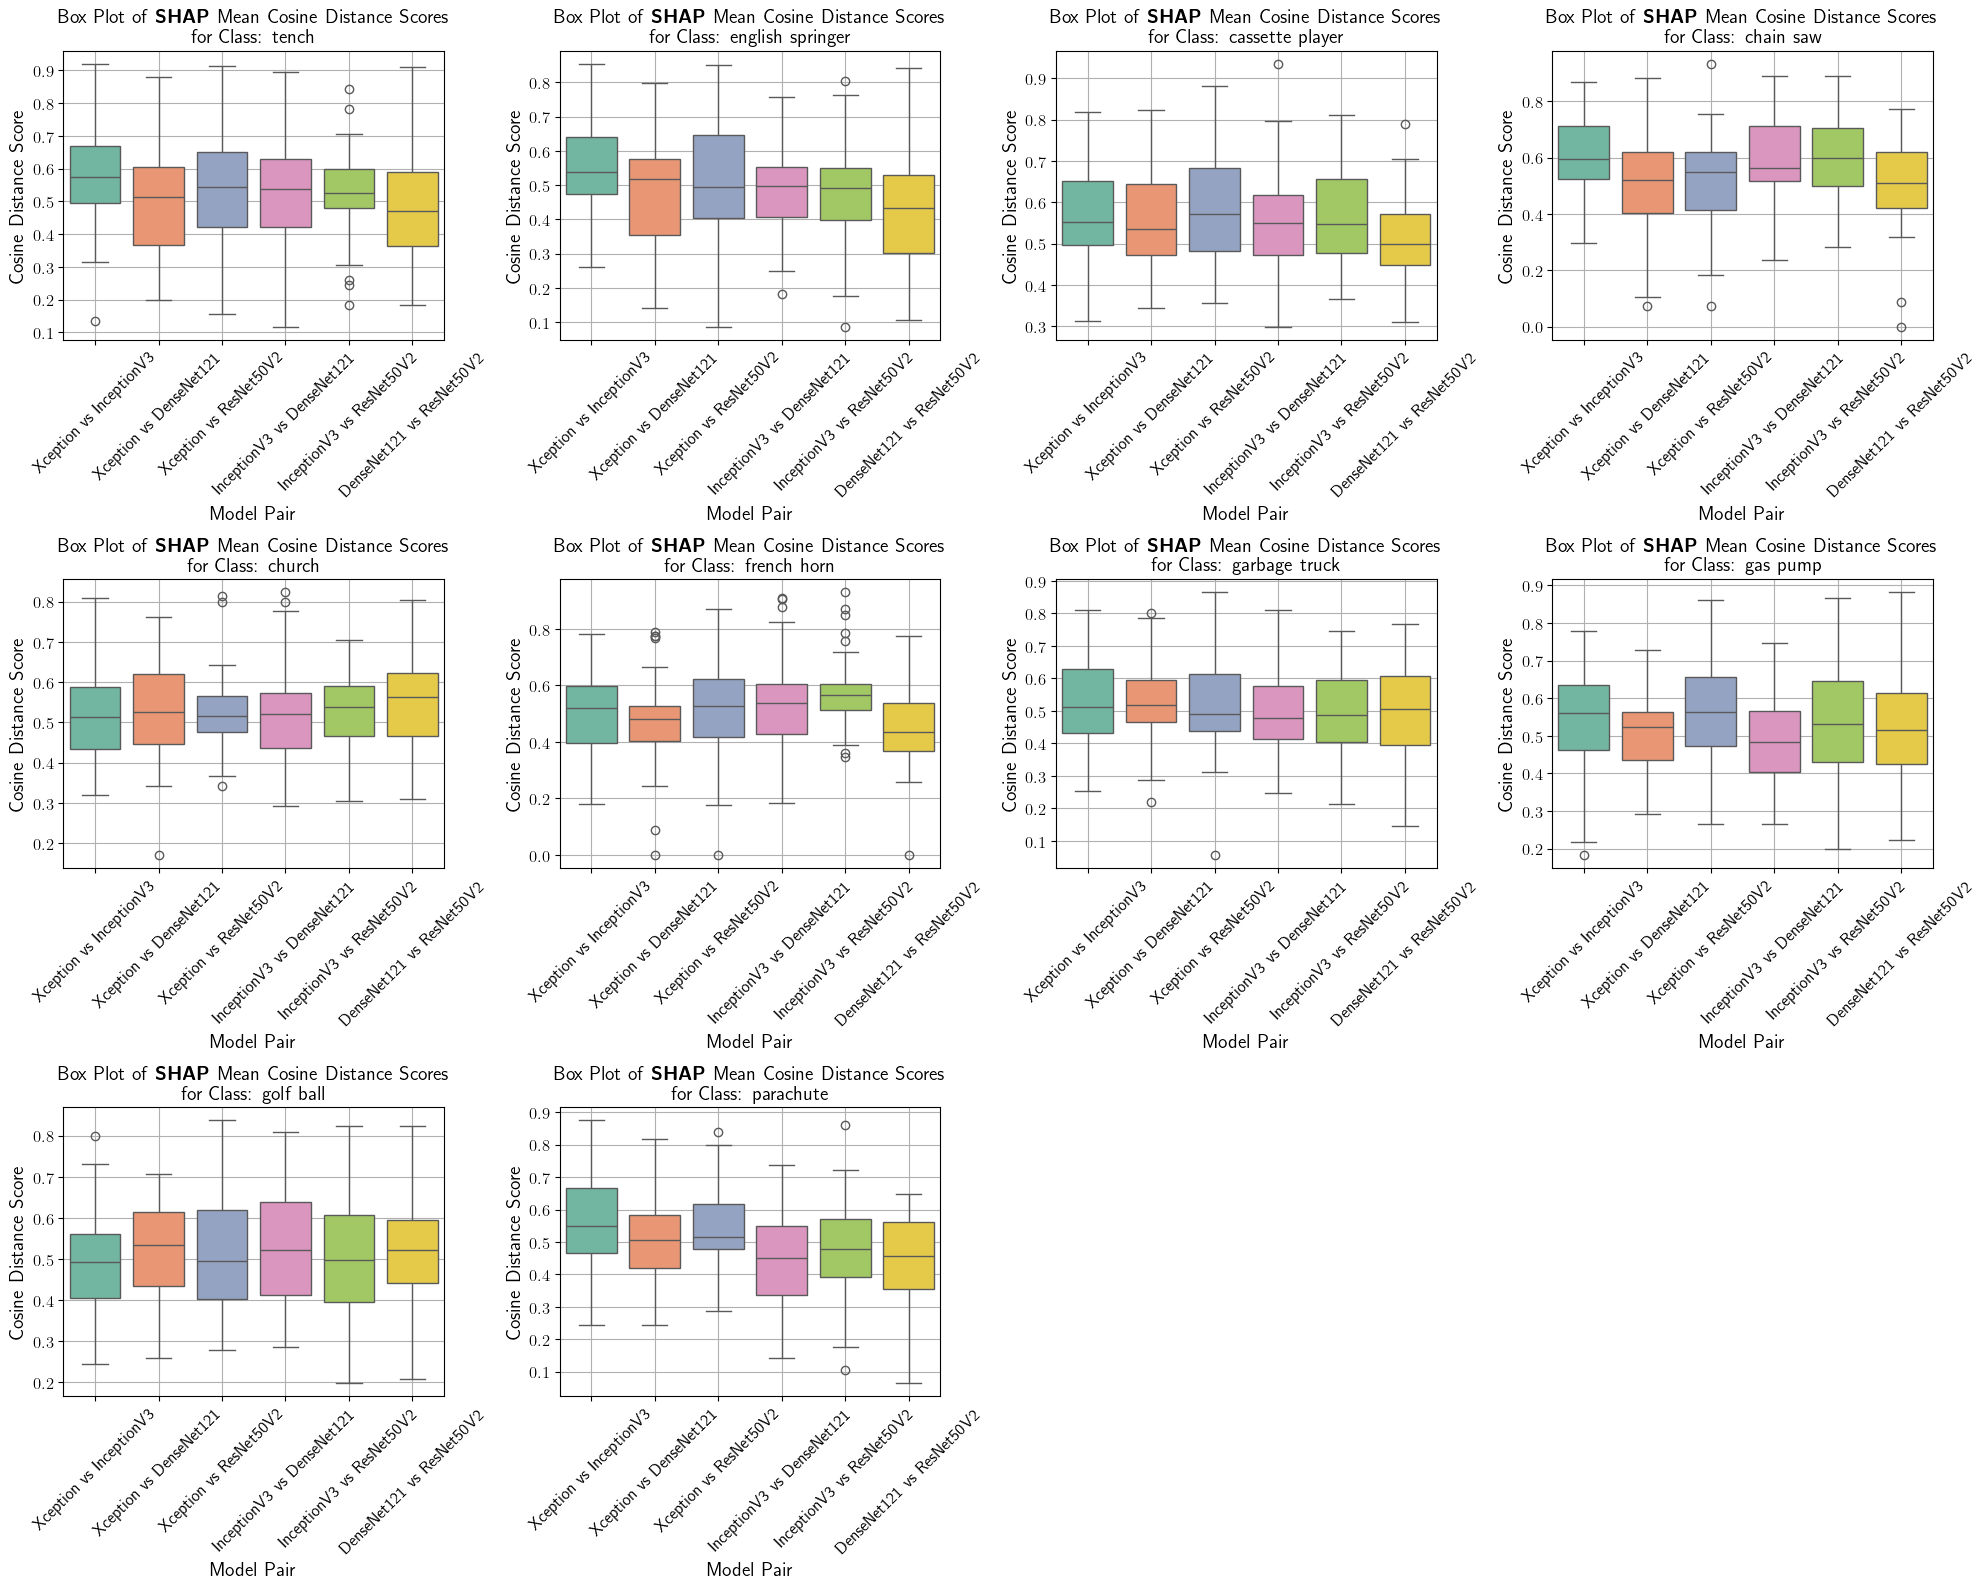

In [32]:
title = 'Box Plot of \\textbf{SHAP} Mean Cosine Distance Scores\n for Class'
plot_class_wise_cosine_distances(class_names, model_extrcs, class_wise_cosine_shap_extrcs, title)

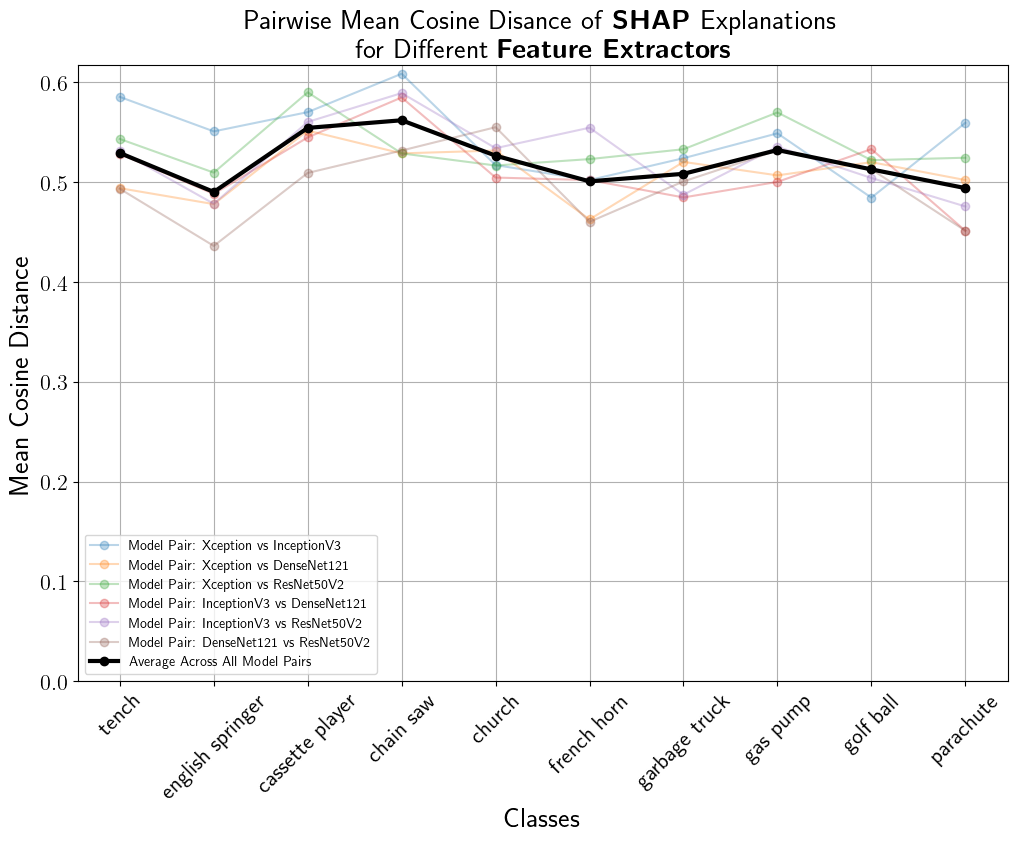

In [33]:
title = "Pairwise Mean Cosine Disance of \\textbf{SHAP} Explanations\nfor Different \\textbf{Feature Extractors}"
plot_mean_cosine_distance_across_classes(distance_dict_shap_extrcs, class_names, title)

In [14]:
model_opts = ["Dense-Adam", "Dense-Nadam", "Dense-RMSprop", "Dense-SGD"]

In [15]:
mask_opts = {class_name: {} for class_name in class_names}

for class_idx, class_name in enumerate(class_names):
    for model_opt in model_opts:
        file_path = f'LIME expls/diff_optimizers/explain_{class_names[class_idx]}_{model_opt}.pkl'

        with open(file_path, 'rb') as file:
            _, mask_opt, _ = pickle.load(file)

        mask_opts[class_name][model_opt] = mask_opt

In [36]:
print(len(mask_opts['tench']['Dense-Adam']))

50


In [16]:
mask_by_class_opt          = organize_by_class(mask_opts, class_names, model_opts)

class_wise_cosine_lime_opt = {class_name: {pair: [] for pair in itertools.combinations(model_opts, 2)} for class_name in class_names}

for class_name in class_names:
    img_masks = [mask_opts[class_name][model_opt] for model_opt in model_opts]
    
    for img_mask in zip(*img_masks):
        for (opt_i, opt_j) in itertools.combinations(model_opts, 2):
            mask_i        = img_mask[model_opts.index(opt_i)]
            mask_j        = img_mask[model_opts.index(opt_j)]
            co_distance   = compute_cosine_distance_lime(mask_i, mask_j) 
            class_wise_cosine_lime_opt[class_name][(opt_i, opt_j)].append(co_distance)
            
distance_dict_lime_opts = {}

for name in class_names:
    distance_dict_lime_opts[name]= compute_mean_distance_lime(expl_list   = mask_by_class_opt[name], 
                                                              model_names = model_opts)

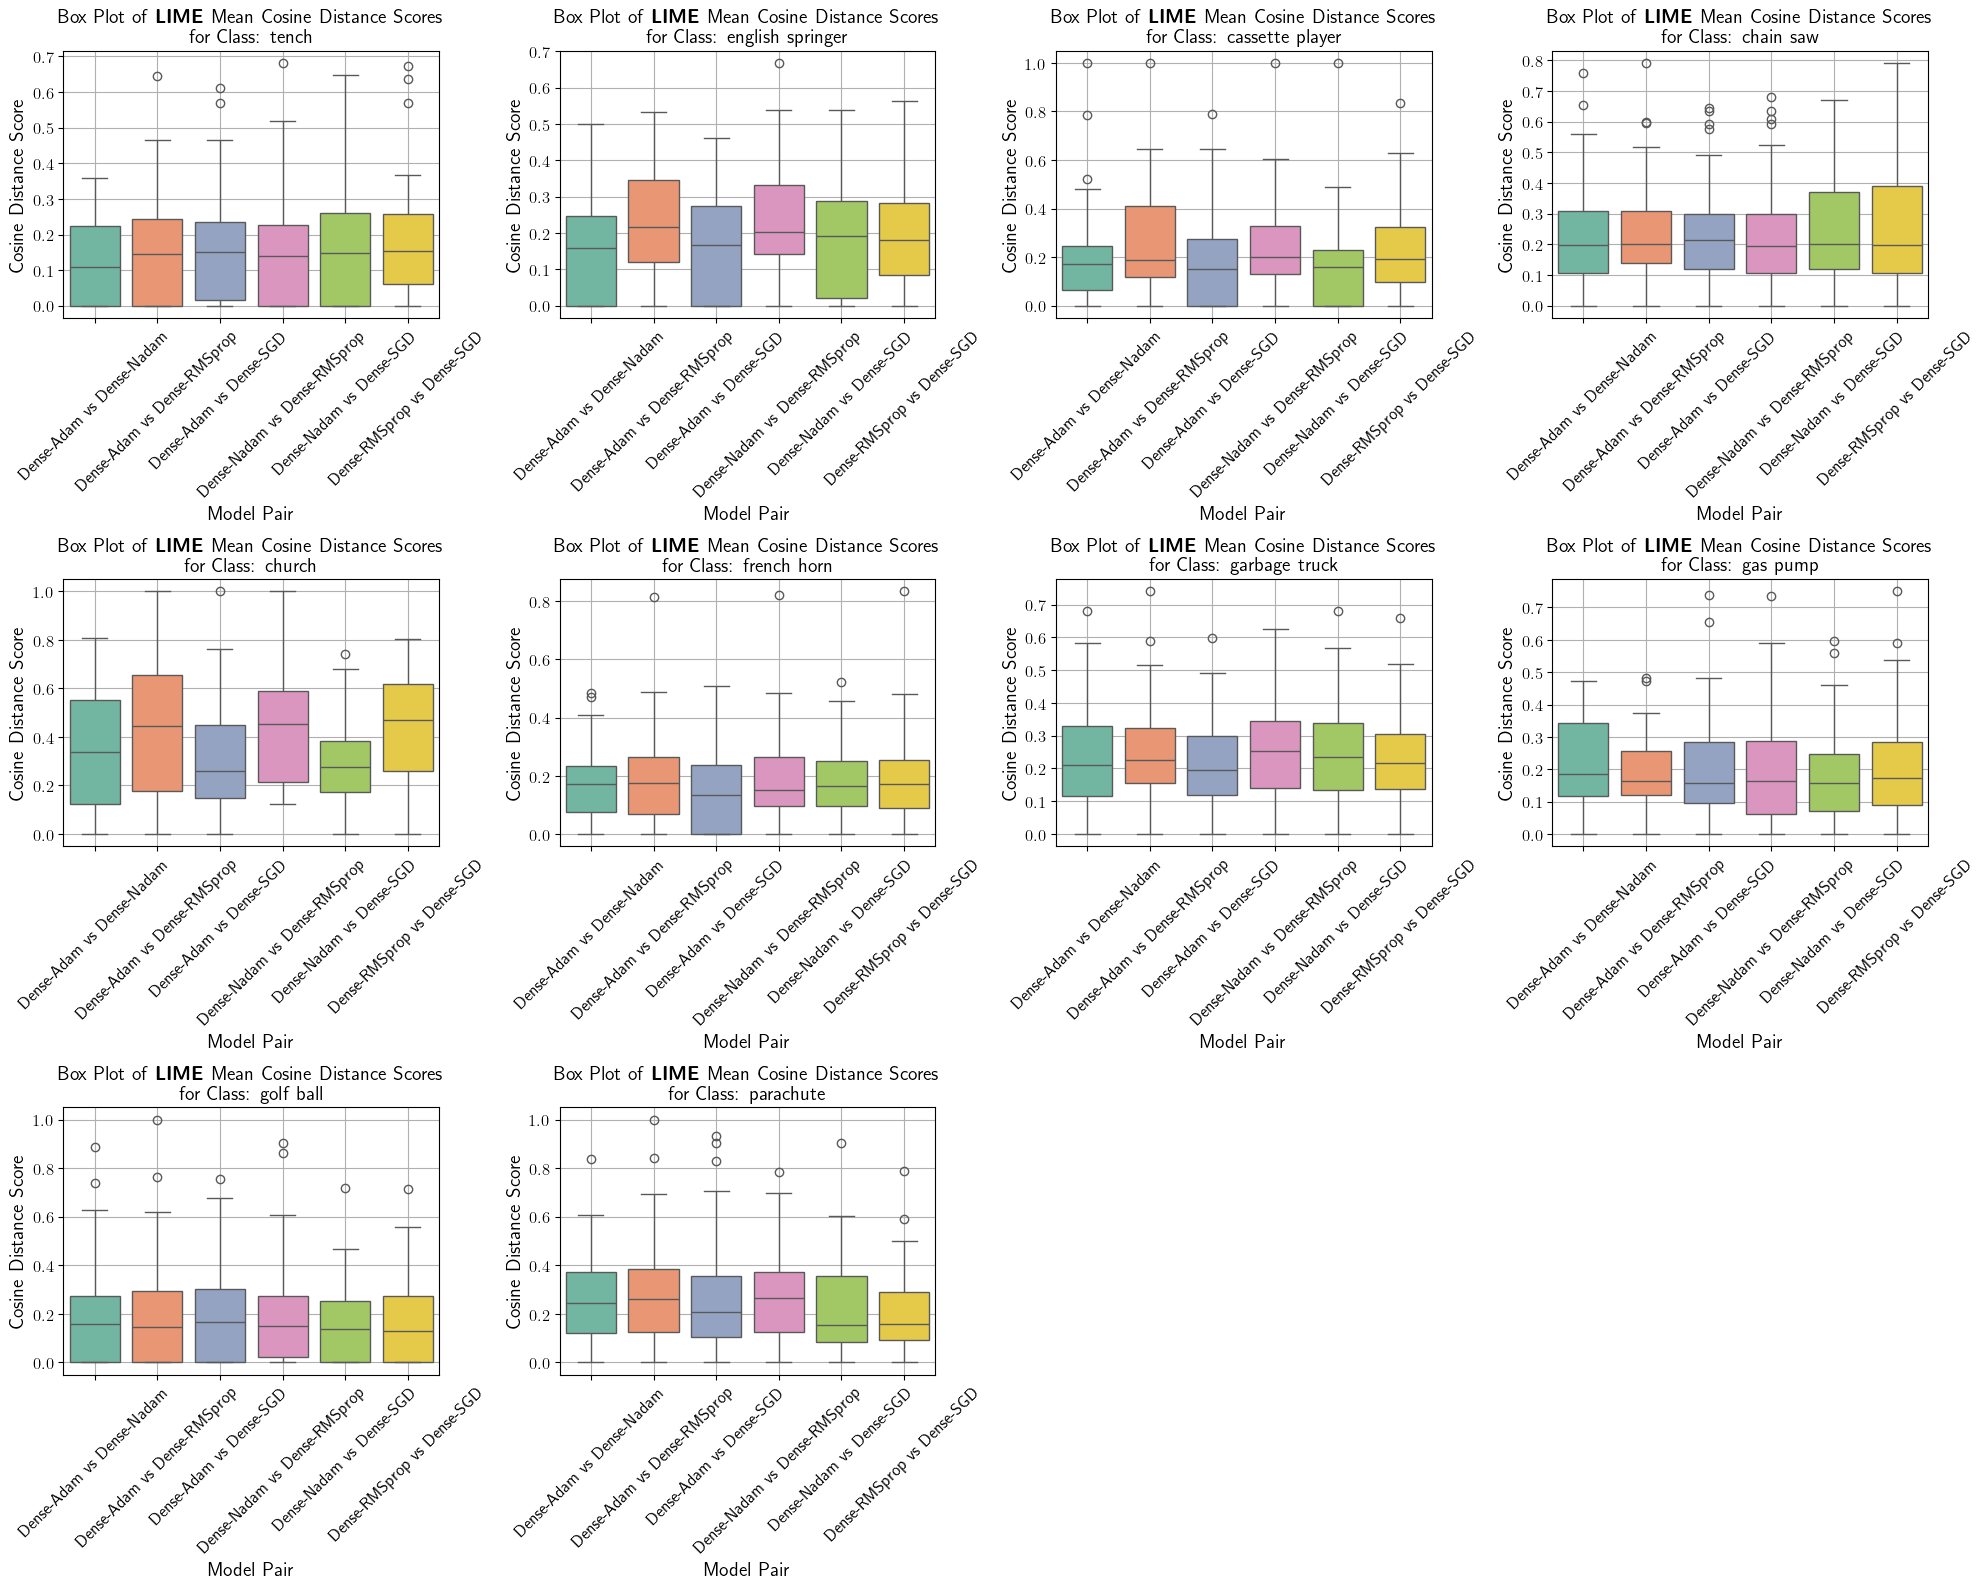

In [38]:
title = 'Box Plot of \\textbf{LIME} Mean Cosine Distance Scores\nfor Class'
plot_class_wise_cosine_distances(class_names, model_opts, class_wise_cosine_lime_opt, title)

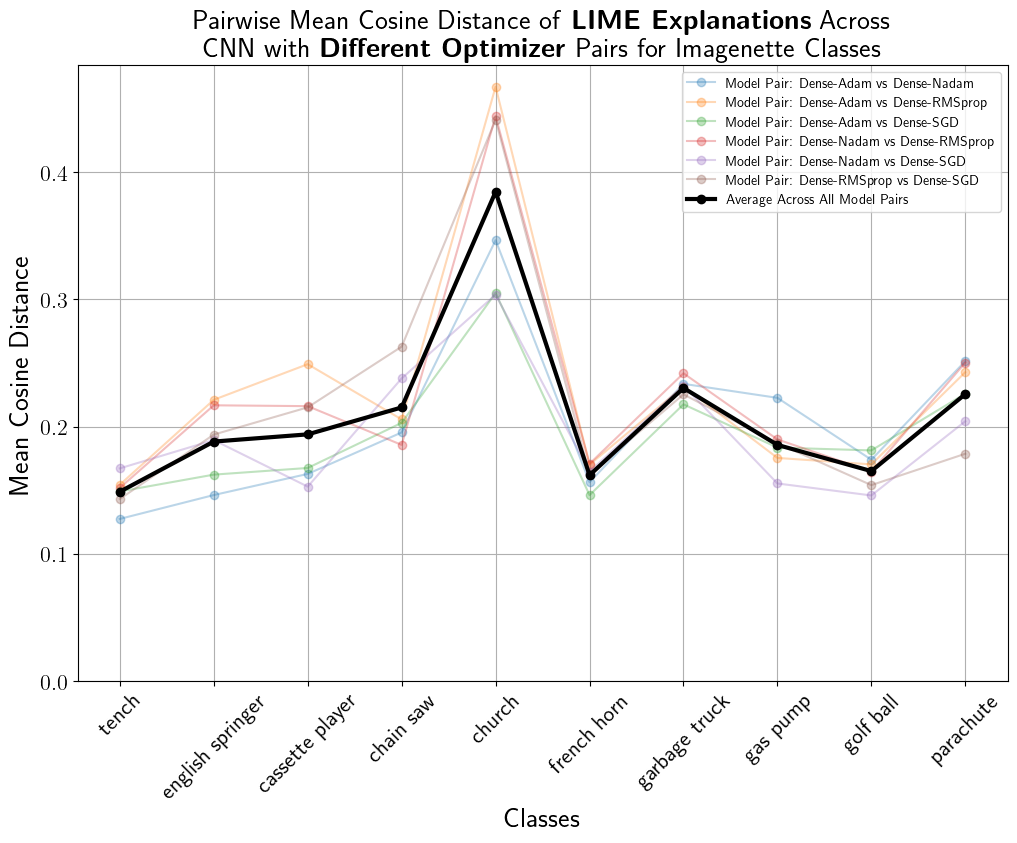

In [39]:
title = 'Pairwise Mean Cosine Distance of \\textbf{LIME Explanations} Across\n CNN with \\textbf{Different Optimizer} Pairs for Imagenette Classes' 
plot_mean_cosine_distance_across_classes(distance_dict_lime_opts, class_names, title)

In [17]:
shap_data_opts = {class_name: {} for class_name in class_names}

for class_idx, class_name in enumerate(class_names):
    for model_opt in model_opts:
        
        file_path = f'SHAP expls/diff_optimizers/explain_{class_names[class_idx]}_{model_opt}_shap.pkl'

        with open(file_path, 'rb') as file:
            data = pickle.load(file)

        shap_data_opts[class_name][model_opt] = data[:50]

In [41]:
print(len(shap_data_opts['tench']['Dense-SGD']))
print(len(shap_data_opts['parachute']['Dense-RMSprop']))

50
50


In [18]:
shap_by_class_opts          = organize_by_class(shap_data_opts, class_names, model_opts)

class_wise_cosine_shap_opts = {class_name: {pair: [] for pair in itertools.combinations(model_opts, 2)} for class_name in class_names}

for class_name in class_names:
    shap_values         = [shap_data_opts[class_name][model_opt] for model_opt in model_opts]
    
    for shap_value in zip(*shap_values):
        for (opt_i, opt_j) in itertools.combinations(model_opts, 2):
            mask_i      = shap_value[model_opts.index(opt_i)]
            mask_j      = shap_value[model_opts.index(opt_j)]
            co_distance = compute_cosine_distance_shap(mask_i, mask_j) 
            class_wise_cosine_shap_opts[class_name][(opt_i, opt_j)].append(co_distance) 

distance_dict_shap_opts  = {}

for name in class_names:
    distance_dict_shap_opts[name] = compute_mean_distance_shap(expl_list   = shap_by_class_opts[name],
                                                               model_names = model_opts)

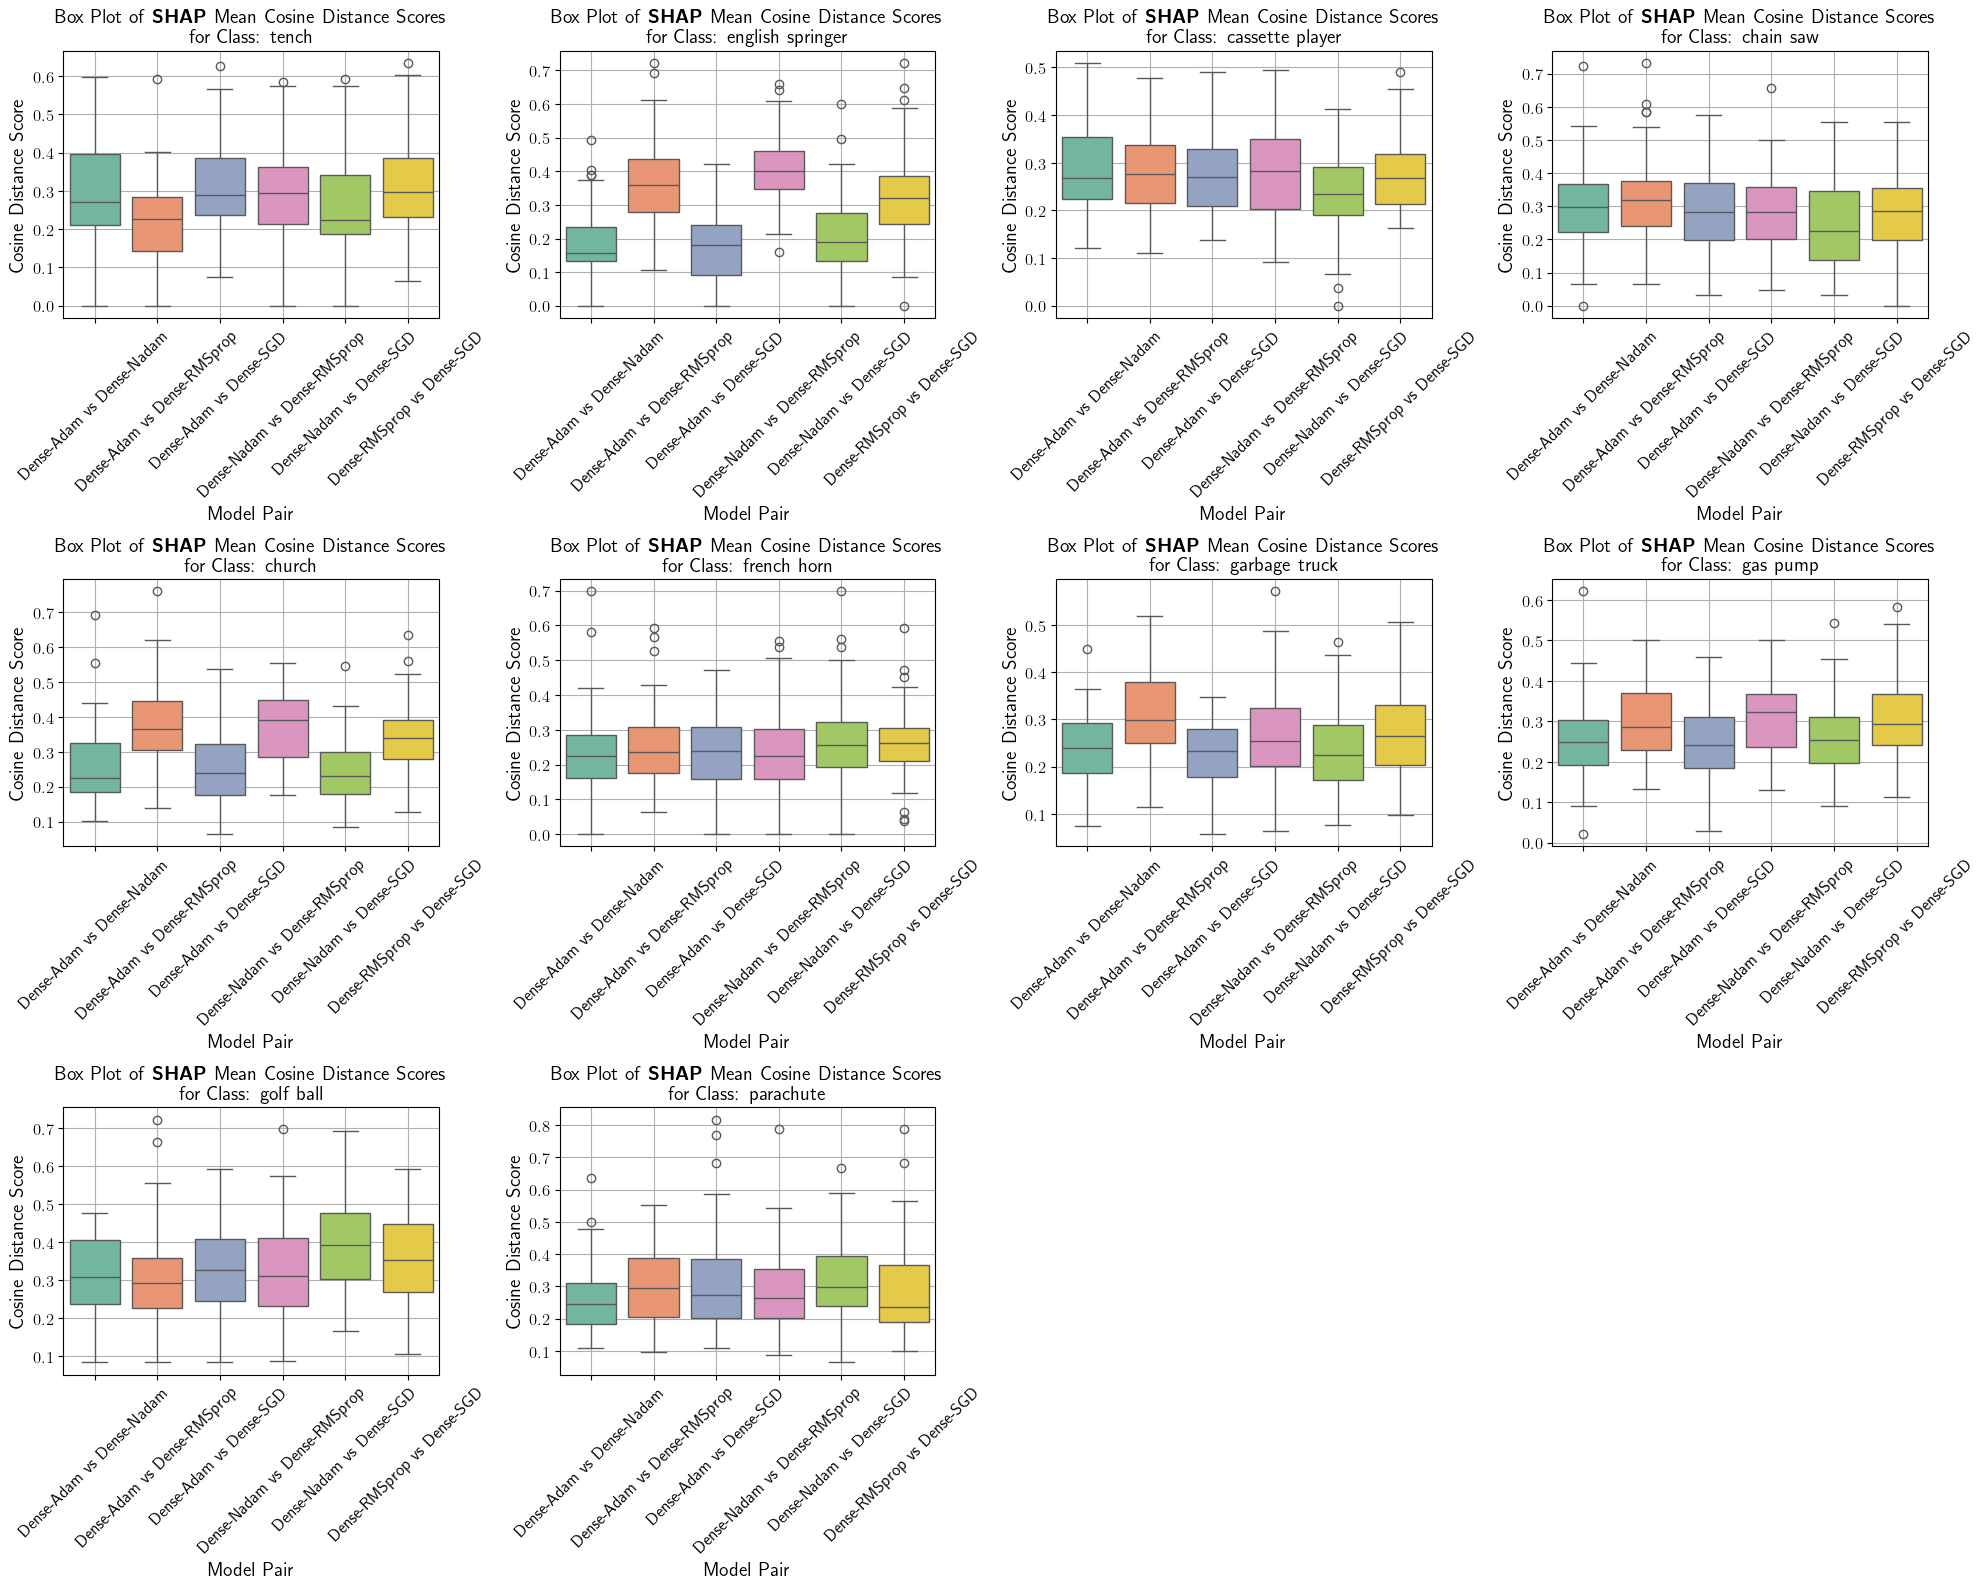

In [43]:
title = 'Box Plot of \\textbf{SHAP} Mean Cosine Distance Scores\nfor Class'
plot_class_wise_cosine_distances(class_names, model_opts, class_wise_cosine_shap_opts, title)

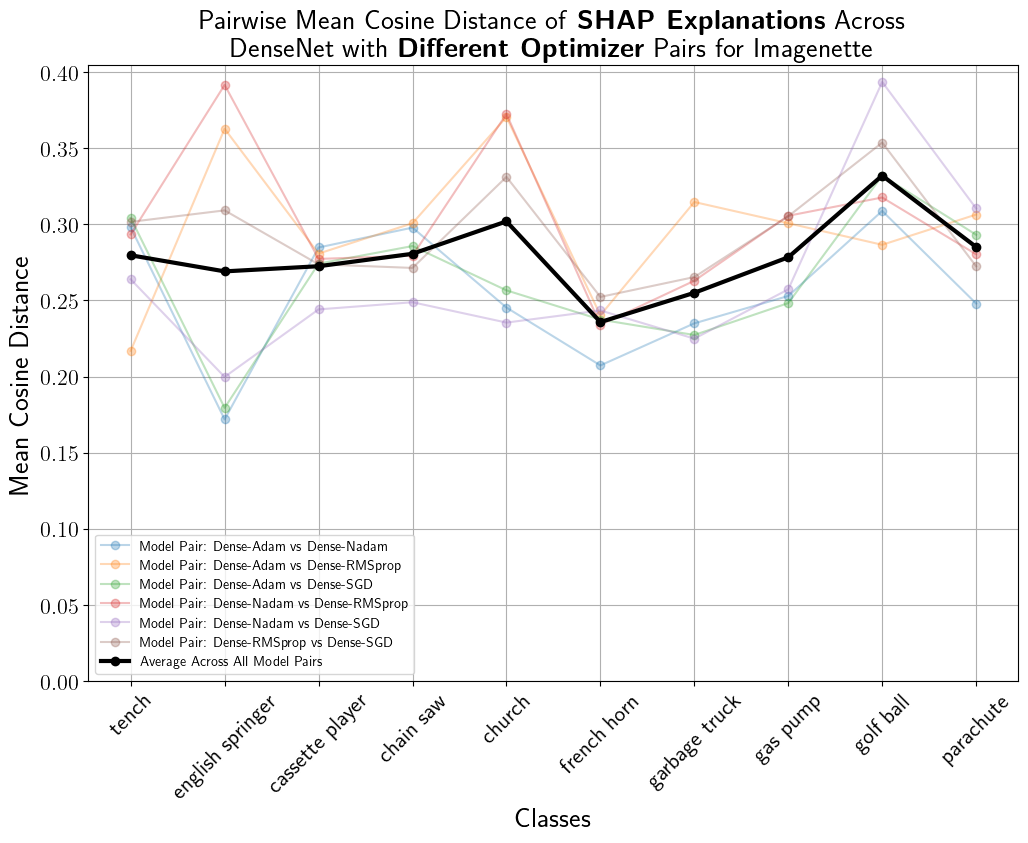

In [44]:
title = 'Pairwise Mean Cosine Distance of \\textbf{SHAP Explanations} Across\n DenseNet with \\textbf{Different Optimizer} Pairs for Imagenette'
plot_mean_cosine_distance_across_classes(distance_dict_shap_opts, class_names, title)

In [19]:
model_seeds = []

for i in range(10):
    seed = f'Dense{i+1}'
    model_seeds.append(seed)

In [20]:
for seed in model_seeds:
    print(seed)

Dense1
Dense2
Dense3
Dense4
Dense5
Dense6
Dense7
Dense8
Dense9
Dense10


In [21]:
mask_seeds      = {class_name: {} for class_name in class_names}

for class_idx, class_name in enumerate(class_names):
    for model_seed in model_seeds:
        
        file_path = f'LIME expls/diff_seeds/explain_{class_names[class_idx]}_{model_seed}.pkl'

        with open(file_path, 'rb') as file:
            _, mask_seed, _       = pickle.load(file)
            
        mask_seeds[class_name][model_seed] = mask_seed[:50]

In [19]:
print(len(mask_seeds['tench']['Dense1']))

50


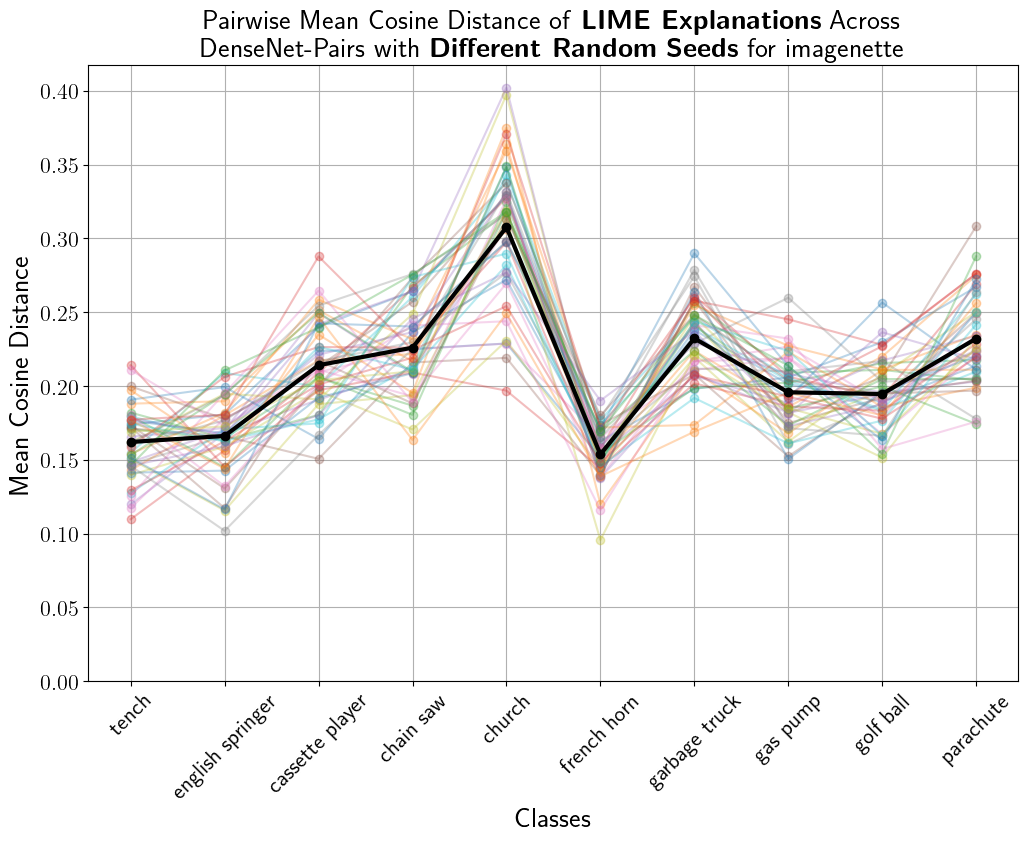

In [22]:
# organize by class
mask_by_class_seeds          = organize_by_class(mask_seeds, class_names, model_seeds)

distance_dict_lime_seeds = {}

for name in class_names:
    distance_dict_lime_seeds[name] = compute_mean_distance_lime(expl_list   = mask_by_class_seeds[name],
                                                                model_names = model_seeds)

# Since we have 10 CNNs, it is difficult to display box-plots of all 10 CNNs. Hence, we skip as previous results can help us understand the performance of CNN over MNIST.

title = 'Pairwise Mean Cosine Distance of \\textbf{LIME Explanations} Across\nDenseNet-Pairs with \\textbf{Different Random Seeds} for imagenette'
plot_mean_cosine_distance_across_classes(distance_dict_lime_seeds, class_names, title, show_legend = False)

In [153]:
# directory = "SHAP expls/diff_seeds/"
# files     = os.listdir(directory)

# for file_name in files:
#     old_file_tag = 'dense'
#     new_file_tag = 'Dense'
#     if old_file_tag in file_name:
#         new_file_name = file_name.replace(old_file_tag, new_file_tag)

#         old_file_path = os.path.join(directory, file_name)
#         new_file_path = os.path.join(directory, new_file_name)

#         os.rename(old_file_path, new_file_path)
#         print(f'Rename: {file_name} >>> {new_file_name}')

In [23]:
# load SHAP data
shap_data_seeds = {class_name: {} for class_name in class_names}

for class_idx, class_name in enumerate(class_names):
    for model_seed in model_seeds:
        
        file_path = f'SHAP expls/diff_seeds/explain_{class_names[class_idx]}_{model_seed}_shap.pkl'

        with open(file_path, 'rb') as file:
            data = pickle.load(file)

        shap_data_seeds[class_name][model_seed] = data[:50]

In [50]:
print(len(shap_data_seeds['parachute']['Dense1']))

50


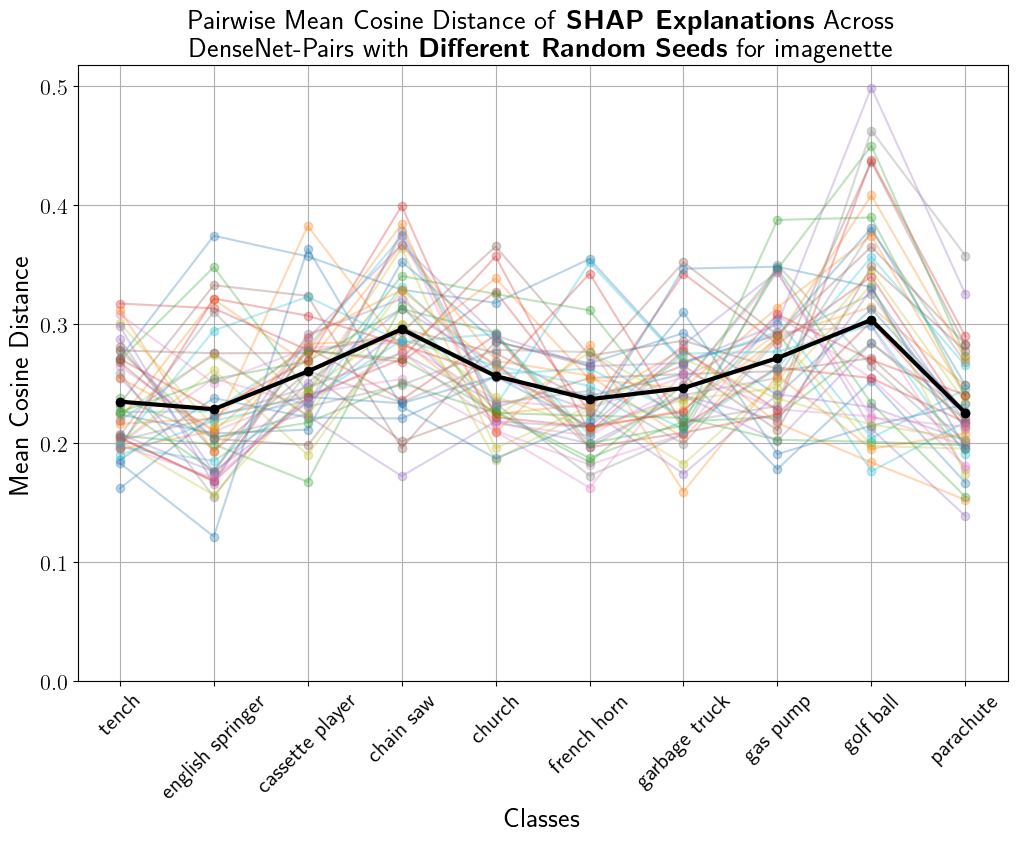

In [24]:
shap_by_class_seeds          = organize_by_class(shap_data_seeds, class_names, model_seeds)

distance_dict_shap_seeds     = {}
for name in class_names:
    distance_dict_shap_seeds[name] = compute_mean_distance_shap(expl_list   = shap_by_class_seeds[name],
                                                                model_names = model_seeds)

title = 'Pairwise Mean Cosine Distance of \\textbf{SHAP Explanations} Across\n DenseNet-Pairs with \\textbf{Different Random Seeds} for imagenette'
plot_mean_cosine_distance_across_classes(distance_dict_shap_seeds, class_names, title, show_legend = False)

In [25]:
def extract_average_score(mean_cosine_scores, classes = class_labels):
    model_pair    = list(mean_cosine_scores[class_labels[0]].keys())
    average_score = []
    
    for class_name in classes:
        score     = np.mean([mean_cosine_scores[class_name][pair] for pair in model_pair])
        average_score.append(score)

    return average_score

In [26]:
avg_model_extrcs_lime   = extract_average_score(distance_dict_lime_extrcs)
avg_model_opts_lime     = extract_average_score(distance_dict_lime_opts)
avg_model_seeds_lime    = extract_average_score(distance_dict_lime_seeds)

data_lime = {
    'Class'            : class_labels,
    'diff extractors'  : avg_model_extrcs_lime,
    'diff optmizers'   : avg_model_opts_lime,
    'diff seeds'       : avg_model_seeds_lime,
}

df_lime = pd.DataFrame(data_lime)
print(df_lime)

              Class  diff extractors  diff optmizers  diff seeds
0             tench         0.268249        0.148882    0.162047
1  english springer         0.344288        0.188285    0.166143
2   cassette player         0.393209        0.193943    0.214083
3         chain saw         0.467907        0.215109    0.225963
4            church         0.452104        0.384615    0.307597
5       french horn         0.383299        0.161855    0.153674
6     garbage truck         0.388570        0.230388    0.232224
7          gas pump         0.408374        0.185657    0.195709
8         golf ball         0.276654        0.165069    0.194549
9         parachute         0.425885        0.225608    0.232121


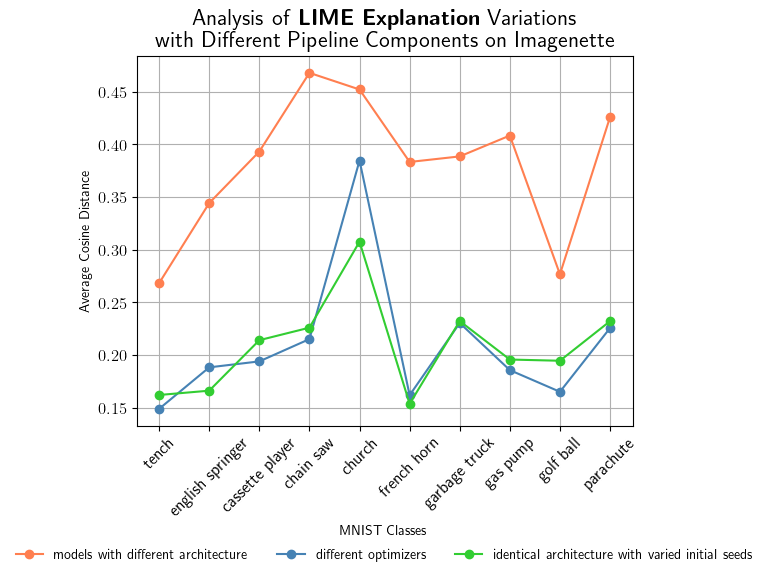

In [27]:
extrcs_plot_lime,  = plt.plot(class_labels, avg_model_extrcs_lime, marker = 'o', color = 'coral', label   = 'models with different architecture')
opts_plot_lime,    = plt.plot(class_labels, avg_model_opts_lime, marker   = 'o', color = '#4682B4', label = 'different optimizers')
seeds_plot_lime,   = plt.plot(class_labels, avg_model_seeds_lime, marker  = 'o', color = '#32CD32', label = 'identical architecture with varied initial seeds')

plt.legend(
    handles        = [extrcs_plot_lime,  opts_plot_lime, seeds_plot_lime],
    loc            = 'upper center',
    bbox_to_anchor = (0.5,-0.30),
    framealpha     = 0.0,
    ncol           = 3
)

# ax = plt.gca()
# ax.set_facecolor('#004C43')
# plt.gcf().set_facecolor('#cec1b3')

plt.title("Analysis of \\textbf{LIME Explanation} Variations\nwith Different Pipeline Components on Imagenette", fontsize=16)
plt.xlabel("MNIST Classes")
plt.ylabel("Average Cosine Distance")
plt.xticks(rotation = 45, fontsize=12)
plt.yticks(fontsize = 12)
plt.grid()
plt.show()

In [28]:
avg_model_extrcs_shap = extract_average_score(distance_dict_shap_extrcs)
avg_model_opts_shap   = extract_average_score(distance_dict_shap_opts)
avg_model_seeds_shap  = extract_average_score(distance_dict_shap_seeds)

data_shap = {
    'Class'            : class_labels,
    'diff extractors'  : avg_model_extrcs_shap,
    'diff optmizers'   : avg_model_opts_shap,
    'diff seeds'       : avg_model_seeds_shap,
}

df_shap  = pd.DataFrame(data_shap)
print(df_shap)

              Class  diff extractors  diff optmizers  diff seeds
0             tench         0.529285        0.279662    0.234832
1  english springer         0.490242        0.269090    0.228430
2   cassette player         0.554467        0.272470    0.260193
3         chain saw         0.562088        0.280637    0.295747
4            church         0.526608        0.301911    0.256314
5       french horn         0.500861        0.235793    0.236848
6     garbage truck         0.508434        0.255018    0.246252
7          gas pump         0.532266        0.278340    0.271456
8         golf ball         0.512857        0.331995    0.303561
9         parachute         0.494126        0.285116    0.225352


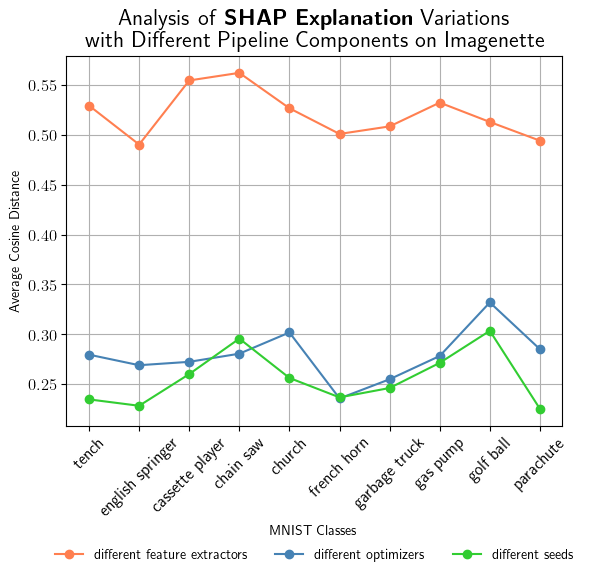

In [29]:
extrcs_plot_shap,  = plt.plot(class_labels, avg_model_extrcs_shap, marker = 'o', color = 'coral', label   = 'different feature extractors')
opts_plot_shap,    = plt.plot(class_labels, avg_model_opts_shap, marker   = 'o', color = '#4682B4', label = 'different optimizers')
seeds_plot_shap,   = plt.plot(class_labels, avg_model_seeds_shap, marker  = 'o', color = '#32CD32', label = 'different seeds')

plt.legend(
    handles        = [extrcs_plot_shap, opts_plot_shap, seeds_plot_shap],
    loc            = 'upper center',
    bbox_to_anchor = (0.5,-0.30),
    framealpha     = 0.0,
    ncol           = 3
)

# ax = plt.gca()
# ax.set_facecolor('#004C43')
# plt.gcf().set_facecolor('#cec1b3')

plt.title("Analysis of \\textbf{SHAP Explanation} Variations\nwith Different Pipeline Components on Imagenette", fontsize=16)
plt.xlabel("MNIST Classes")
plt.ylabel("Average Cosine Distance")
plt.xticks(rotation = 45, fontsize=12)
plt.yticks(fontsize = 12)
plt.grid()
plt.show()

In [108]:
# Appendix

In [ ]:
# Appendix: OOD Generalization Analysis

In [22]:
imagenette_testset = tf.data.Dataset.load("test_dataset")
gaussian_testset   = tf.data.Dataset.load("ood_data/gaussian_testset")
brightness_testset = tf.data.Dataset.load("ood_data/brightness_testset")
fog_testset        = tf.data.Dataset.load("ood_data/fog_testset")
contrast_testset   = tf.data.Dataset.load("ood_data/contrast_testset")

2024-10-25 10:19:24.460083: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [31]:
diff_extractors     = []

model_ext_directory = 'models/diff_extrcs/'

for model_file in os.listdir(model_ext_directory):
    if model_file.endswith(".h5"):
        model_path  = os.path.join(model_ext_directory, model_file)
        model       = tf.keras.models.load_model(model_path)
        diff_extractors.append(model)

In [32]:
for model in diff_extractors:
    print(model.name)

Xception_imgnette
InceptionV3_imgnette
DenseNet121_imgnette
Res50_imgnette


In [82]:
datasets     = {
    'Imagenette Testset' : imagenette_testset,
    'Gaussain Testset'   : gaussian_testset,
    'Brightness Testset' : brightness_testset,
    'Fog Testset'        : fog_testset,
    'Contrast Testset'   : contrast_testset
}

model_extrcs = {
    'Xception'           : diff_extractors[0],
    'InceptionV3'        : diff_extractors[1],
    'DenseNet121'        : diff_extractors[2],
    'ResNet50V2'         : diff_extractors[3]
}

In [83]:
def get_model_size(model):
    num_params    = model.count_params()
    size_in_bytes = num_params * 4             # assuming 4 bytes per parameter
    size_in_mb    = size_in_bytes/ (1024 **2)
    return round(size_in_mb)

model_sizes       = {model_name : get_model_size(model) for model_name, model in model_extrcs.items()}

In [84]:
model_sizes

{'Xception': 84, 'InceptionV3': 87, 'DenseNet121': 29, 'ResNet50V2': 94}

In [85]:
results = {dataset_name: [] for dataset_name in datasets.keys()}

In [89]:
results

{'Imagenette Testset': [],
 'Gaussain Testset': [],
 'Brightness Testset': [],
 'Fog Testset': [],
 'Contrast Testset': []}

In [91]:
for model_name, model in model_extrcs.items():
    for dataset_name, dataset in datasets.items():
        loss, acc, pre, re, auc, f1 = model.evaluate(dataset)
        results[dataset_name].append(acc)

12/12 [==============================] - 2s 173ms/step - loss: 0.1668 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9935 - f1_score: 0.9616


In [92]:
df                     = pd.DataFrame(results, index = model_extrcs.keys())
df.reset_index(inplace = True)
df['Model Size (MB)']  = pd.Series(model_sizes.values())
df                     = df.round(4)
df

index  Imagenette Testset  Gaussain Testset  Brightness Testset  \
0     Xception              0.9831            0.8867              0.9544   
1  InceptionV3              0.9740            0.8841              0.9518   
2  DenseNet121              0.9805            0.8477              0.9362   
3   ResNet50V2              0.9805            0.8815              0.9401   

   Fog Testset  Contrast Testset  Model Size (MB)  
0       0.9154            0.9648               84  
1       0.9232            0.9635               87  
2       0.8867            0.9596               29  
3       0.9049            0.9622               94

In [94]:
diff_opts           = []

model_ext_directory = 'models/diff_optimizers/'

for model_file in os.listdir(model_ext_directory):
    if model_file.endswith(".h5"):
        model_path  = os.path.join(model_ext_directory, model_file)
        model       = tf.keras.models.load_model(model_path)
        diff_opts.append(model)

for model in diff_opts:
    print(model.name)

DenseNet121_rmsp
DenseNet121_adam
DenseNet121_SGD
DenseNet121_nadam


In [97]:
model_opts   = {
    'RMSprop'  : diff_opts[0],
    'Adam'     : diff_opts[1],
    'SGD'      : diff_opts[2],
    'Nadam'    : diff_opts[3]
}

results_opts = {dataset_name: [] for dataset_name in datasets.keys()}

for model_name, model in model_opts.items():
    for dataset_name, dataset in datasets.items():
        loss, acc, pre, re, auc, f1 = model.evaluate(dataset)
        results_opts[dataset_name].append(acc)

12/12 [==============================] - 3s 241ms/step - loss: 0.1679 - accuracy: 0.9583 - precision: 0.9620 - recall: 0.9570 - auc: 0.9955 - f1_score: 0.9584


In [98]:
df                     = pd.DataFrame(results_opts, index = model_opts.keys())
df.reset_index(inplace = True)
df                     = df.round(4)
df

index  Imagenette Testset  Gaussain Testset  Brightness Testset  \
0  RMSprop              0.9844            0.8529              0.9440   
1     Adam              0.9818            0.8698              0.9323   
2      SGD              0.9857            0.8711              0.9466   
3    Nadam              0.9857            0.8607              0.9453   

   Fog Testset  Contrast Testset  
0       0.9036            0.9635  
1       0.8932            0.9583  
2       0.9049            0.9635  
3       0.9049            0.9583

In [101]:
diff_seeds          = []

directory           = 'models/diff_seeds/'

for model_file in os.listdir(directory):
    if model_file.endswith(".h5"):
        model_path  = os.path.join(directory, model_file)
        model       = tf.keras.models.load_model(model_path)
        diff_seeds.append(model)

for i, model in enumerate(diff_seeds):
    model._name = f'Seed{i}'
    print(model.name)

Seed0
Seed1
Seed2
Seed3
Seed4
Seed5
Seed6
Seed7
Seed8
Seed9


In [105]:
model_seeds   = {model.name : model for model in diff_seeds}

results_seeds = {dataset_name: [] for dataset_name in datasets.keys()}

for model_name, model in model_seeds.items():
    for dataset_name, dataset in datasets.items():
        loss, acc, pre, re, auc, f1 = model.evaluate(dataset)
        results_seeds[dataset_name].append(acc)

12/12 [==============================] - 3s 242ms/step - loss: 0.1698 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9505 - auc: 0.9939 - f1_score: 0.9526


In [106]:
df                     = pd.DataFrame(results_seeds, index = model_seeds.keys())
df.reset_index(inplace = True)
df                     = df.round(4)
df

index  Imagenette Testset  Gaussain Testset  Brightness Testset  \
0  Seed0              0.9818            0.8880              0.9440   
1  Seed1              0.9805            0.8659              0.9388   
2  Seed2              0.9818            0.8776              0.9518   
3  Seed3              0.9818            0.8685              0.9388   
4  Seed4              0.9831            0.8880              0.9466   
5  Seed5              0.9844            0.8763              0.9414   
6  Seed6              0.9753            0.8828              0.9401   
7  Seed7              0.9792            0.8997              0.9427   
8  Seed8              0.9844            0.8776              0.9492   
9  Seed9              0.9779            0.8503              0.9388   

   Fog Testset  Contrast Testset  
0       0.9076            0.9622  
1       0.9023            0.9557  
2       0.9128            0.9570  
3       0.9036            0.9609  
4       0.9167            0.9661  
5       0.9102            0.9635  
6       0.8984            0.9505  
7       0.9245            0.9531  
8       0.9180            0.9714  
9       0.8802            0.9518

(-0.5, 223.5, 223.5, -0.5)

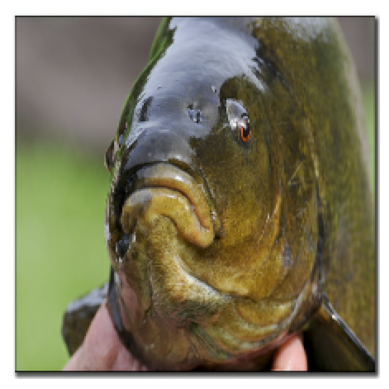

In [241]:
import LIME

img_batch, label_batch = next(iter(imagenette_testset))
test_sample            = np.array(img_batch[44])
test_sample_label      = np.array(label_batch[44])

plt.imshow(test_sample)
plt.axis('off')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

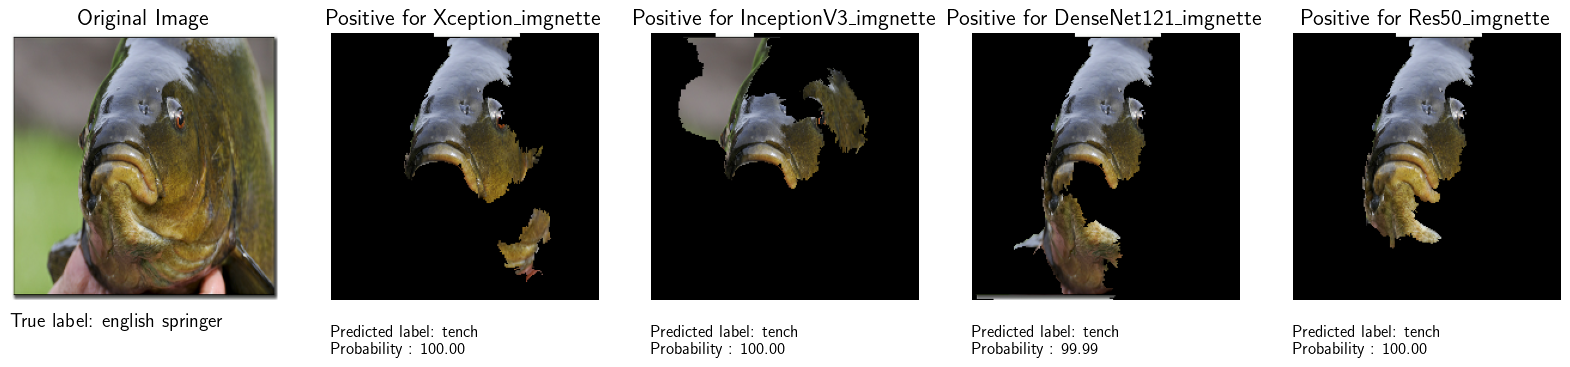

In [242]:
temp_extrcs  = []
mask_extrcs  = []

plt.figure(figsize = (20,20))
plt.subplot(1, 5, 1)
plt.imshow(test_sample)
plt.title(f'Original Image', fontsize = 16)
plt.text(0,-0.1,
            f'True label: {class_labels[np.argmax(label_batch[0])]}',
            fontsize  = 14,
            transform = plt.gca().transAxes)
plt.axis('off')

for model_idx, model in enumerate(diff_extractors):
    temp, mask,_ = LIME.explain_aninstance(test_sample, model)
    pred         = LIME.prediction_fn(test_sample, model)
    pred_label   = class_labels[np.argmax(pred)]
    prob         = np.max(pred) * 100
    temp_extrcs.append(temp)
    mask_extrcs.append(mask)
    
    plt.subplot(1, 5, model_idx+2)
    plt.imshow(temp)
    plt.title(f'Positive for {model.name}', fontsize = 16)
    plt.text(0,-0.2,
            f'Predicted label: {pred_label}\nProbability    : {prob:.2f}%',
            fontsize  = 12,
            transform = plt.gca().transAxes)
    plt.axis('off')

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

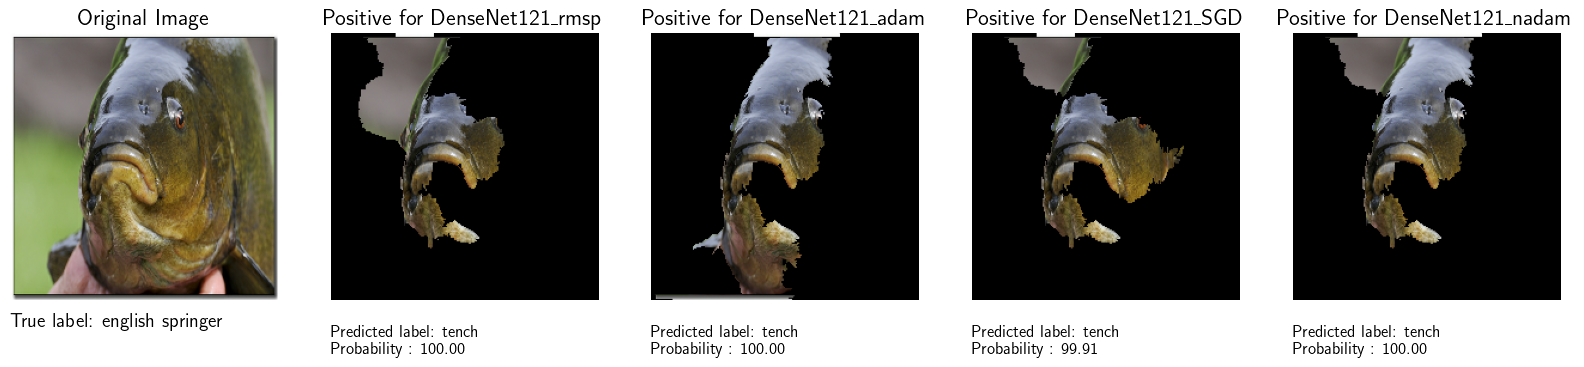

In [245]:
temp_opts  = []
mask_opts  = []

plt.figure(figsize = (20,20))
plt.subplot(1, 5, 1)
plt.imshow(test_sample)
plt.title(f'Original Image', fontsize = 16)
plt.text(0,-0.1,
            f'True label: {class_labels[np.argmax(label_batch[0])]}',
            fontsize  = 14,
            transform = plt.gca().transAxes)
plt.axis('off')

for model_idx, model in enumerate(diff_opts):
    temp, mask,_ = LIME.explain_aninstance(test_sample, model)
    pred         = LIME.prediction_fn(test_sample, model)
    pred_label   = class_labels[np.argmax(pred)]
    prob         = np.max(pred) * 100
    temp_opts.append(temp)
    mask_opts.append(mask)
    
    plt.subplot(1, 5, model_idx+2)
    plt.imshow(temp)
    plt.title(f'Positive for {model.name}', fontsize = 16)
    plt.text(0,-0.2,
            f'Predicted label: {pred_label}\nProbability    : {prob:.2f}%',
            fontsize  = 12,
            transform = plt.gca().transAxes)
    plt.axis('off')

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

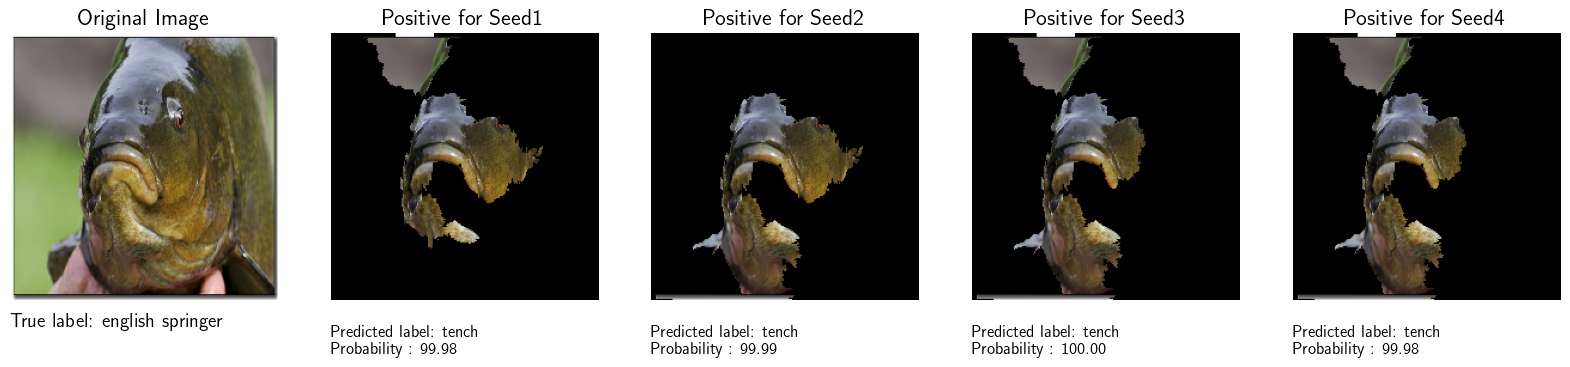

In [244]:
temp_seeds  = []
mask_seeds  = []

plt.figure(figsize = (20,20))
plt.subplot(1, 5, 1)
plt.imshow(test_sample)
plt.title(f'Original Image', fontsize = 16)
plt.text(0,-0.1,
            f'True label: {class_labels[np.argmax(label_batch[0])]}',
            fontsize  = 14,
            transform = plt.gca().transAxes)
plt.axis('off')

for model_idx, model in enumerate(diff_seeds[:4]):
    temp, mask,_ = LIME.explain_aninstance(test_sample, model)
    pred         = LIME.prediction_fn(test_sample, model)
    pred_label   = class_labels[np.argmax(pred)]
    prob         = np.max(pred) * 100
    temp_seeds.append(temp)
    mask_seeds.append(mask)
    
    plt.subplot(1, 5, model_idx+2)
    plt.imshow(temp)
    plt.title(f'Positive for Seed{model_idx+1}', fontsize = 16)
    plt.text(0,-0.2,
            f'Predicted label: {pred_label}\nProbability    : {prob:.2f}%',
            fontsize  = 12,
            transform = plt.gca().transAxes)
    plt.axis('off')

plt.show()

In [130]:
# # Rescale instance to [0, 255] and convert to uint8
# instance = (img * 255).astype(np.uint8)
# instance_batched = np.expand_dims(instance, axis=0)

# print(instance.shape)  # Should print (224, 224, 3)
# print(instance.dtype)  # Should print uint8
# print(type(instance))

test_sample.shape

(224, 224, 3)

In [166]:
import shap
import importlib
importlib.reload(shap)
masker     = shap.maskers.Image("inpaint_telea", (224,224,3))

def predict_fn(images, model):
    # Convert images back to float32 in [0, 1] for the model
    images = images.astype(np.float32) / 255.0
    return model.predict(images, verbose=0)

Iteration : 1


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.68s/it]                                                                    


SHAP vizualization for model : Xception_imgnette


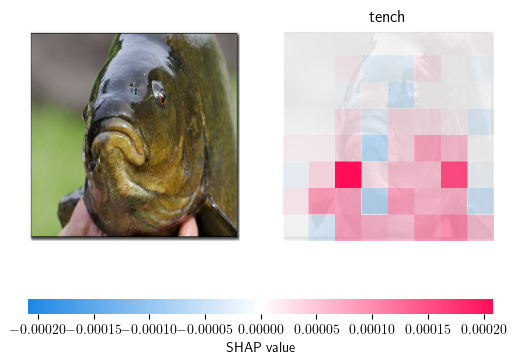

Iteration : 2


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.31s/it]                                                                    

SHAP vizualization for model : InceptionV3_imgnette


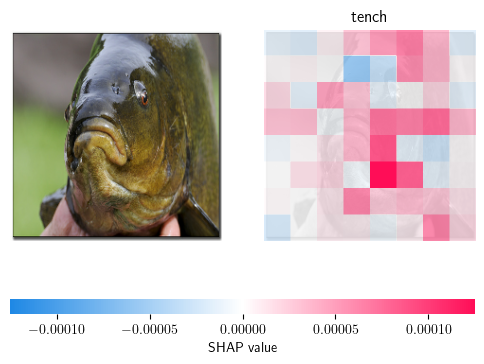

Iteration : 3


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.67s/it]                                                                    


SHAP vizualization for model : DenseNet121_imgnette


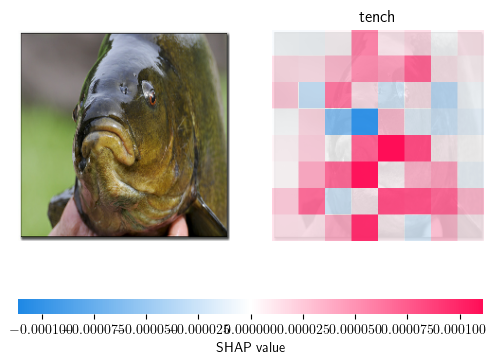

Iteration : 4


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.96s/it]                                                                    

SHAP vizualization for model : Res50_imgnette


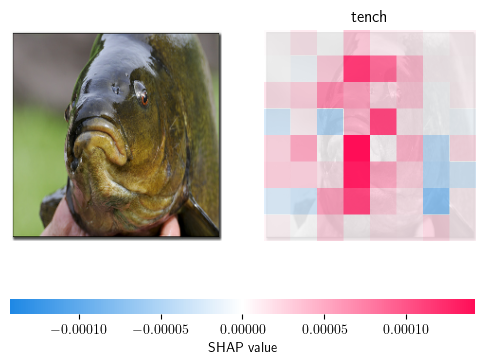

In [246]:
shap_diff_extractros = []

for idx, model in enumerate(diff_extractors):
    print("Iteration :", idx+1)

    img       = (test_sample * 255).astype(np.uint8)
    img       = np.expand_dims(img, axis = 0)
    explainer = shap.Explainer(lambda x : predict_fn(x, model),
                               masker,
                               output_names = class_labels)
    
    shap_values = explainer(img,
                            batch_size      = 500,
                            max_evals       = 1000,
                            outputs         = shap.Explanation.argsort.flip[:1])
    
    shap_diff_extractros.append(shap_values)
    
    print(f'SHAP vizualization for model : {model.name}')
    shap.image_plot(shap_values)

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


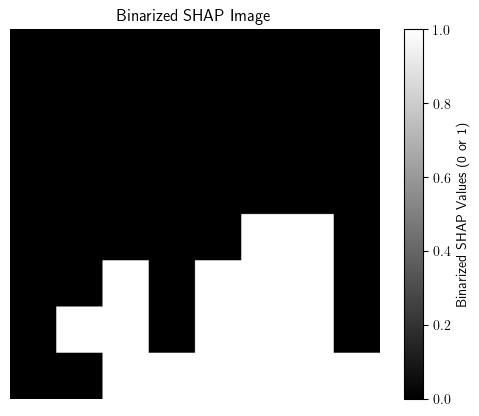

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


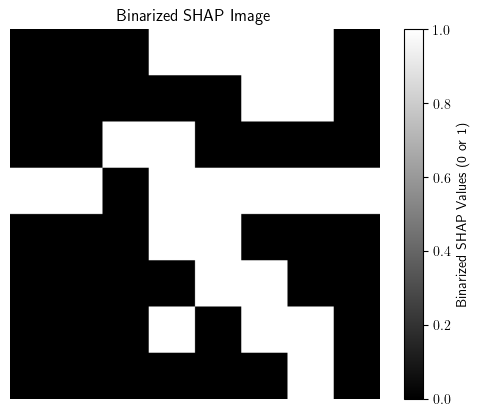

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


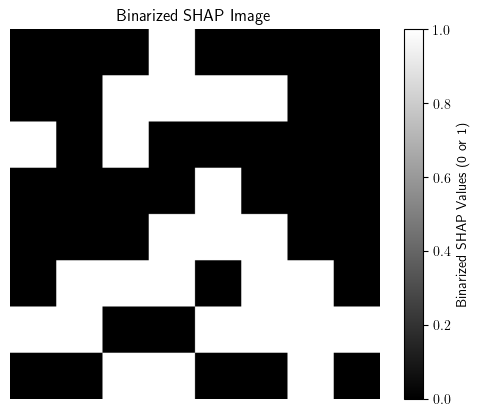

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


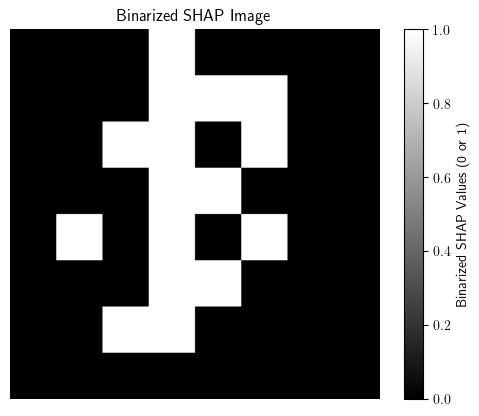

In [247]:
for i, mask in enumerate(shap_diff_extractros):
    shap_img = mask
    visualize_binarized_shap(shap_img)

Iteration : 1


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.96s/it]                                                                    

SHAP vizualization for model : DenseNet121_rmsp


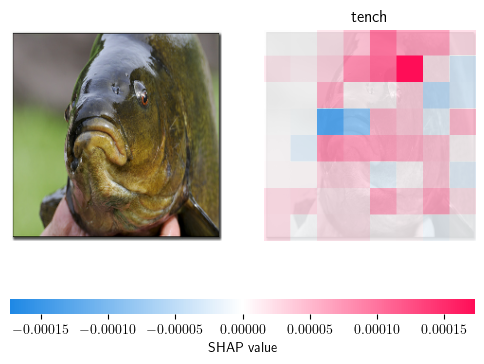

Iteration : 2


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.72s/it]                                                                    

SHAP vizualization for model : DenseNet121_adam


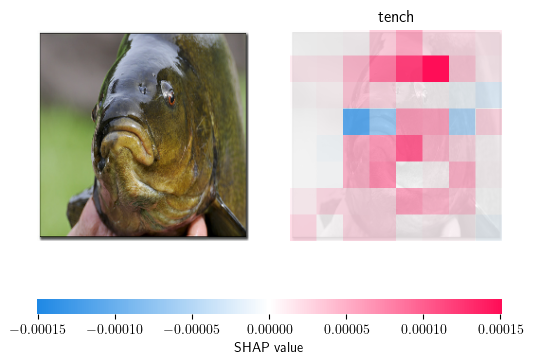

Iteration : 3


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.52s/it]                                                                    

SHAP vizualization for model : DenseNet121_SGD


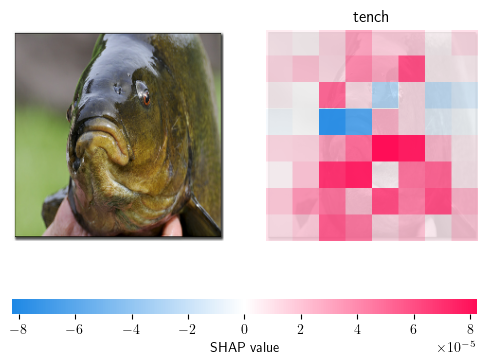

Iteration : 4


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.65s/it]                                                                    

SHAP vizualization for model : DenseNet121_nadam


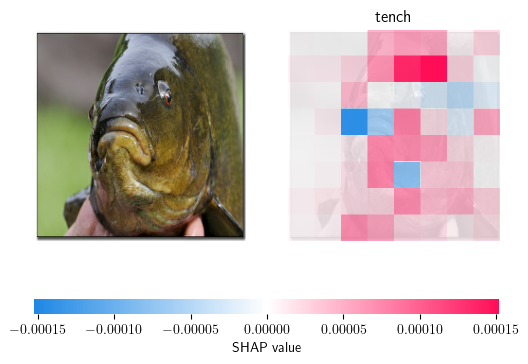

In [248]:
shap_diff_optimizers = []

for idx, model in enumerate(diff_opts):
    print("Iteration :", idx+1)

    # img     = np.array(image) if not isinstance(test_sample, np.ndarray) else test_sample
    img       = (test_sample * 255).astype(np.uint8)
    img       = np.expand_dims(img, axis = 0)
    explainer = shap.Explainer(lambda x : predict_fn(x, model),
                               masker,
                               output_names = class_labels)
    
    shap_values = explainer(img,
                            batch_size      = 500,
                            max_evals       = 1000,
                            outputs         = shap.Explanation.argsort.flip[:1])
    
    shap_diff_optimizers.append(shap_values)
    
    print(f'SHAP vizualization for model : {model.name}')
    shap.image_plot(shap_values)

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


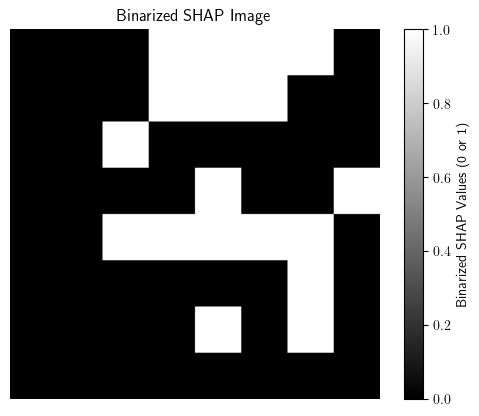

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


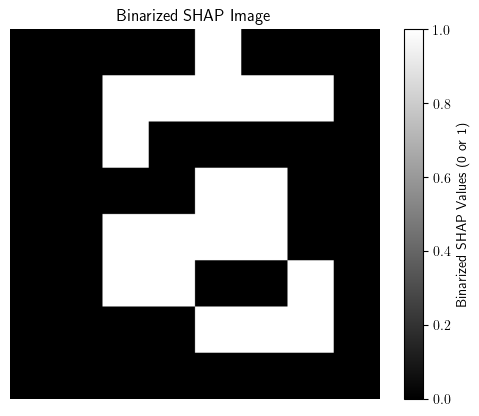

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


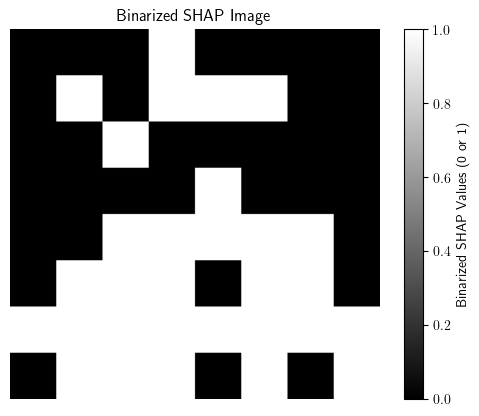

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


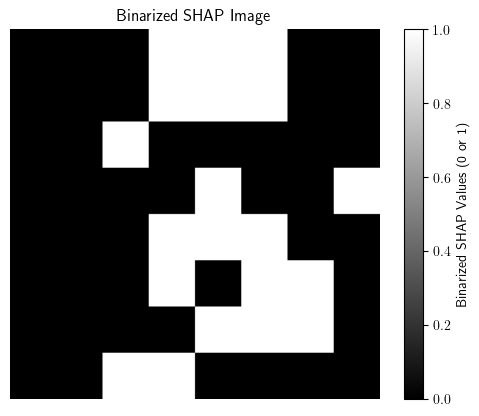

In [249]:
for i, mask in enumerate(shap_diff_optimizers):
    shap_img = mask
    visualize_binarized_shap(shap_img)

Iteration : 1


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.58s/it]                                                                    

SHAP vizualization for model : Seed0


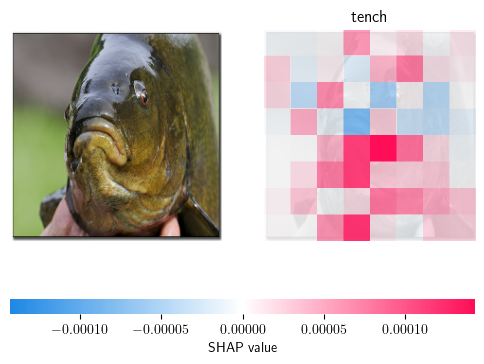

Iteration : 2


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.85s/it]                                                                    


SHAP vizualization for model : Seed1


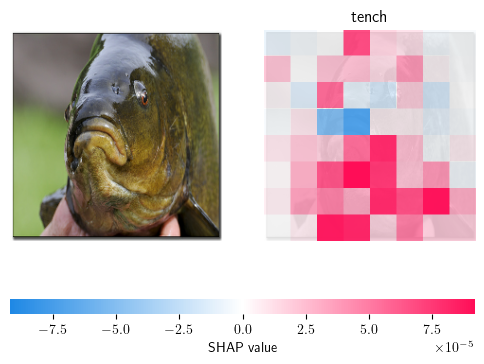

Iteration : 3


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.18s/it]                                                                    

SHAP vizualization for model : Seed2


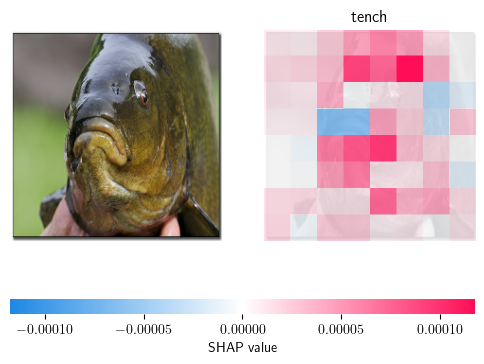

Iteration : 4


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.93s/it]                                                                    

SHAP vizualization for model : Seed3


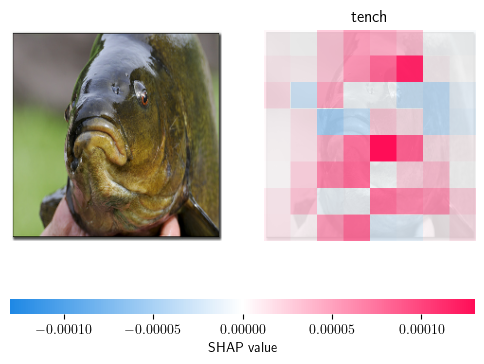

In [250]:
shap_diff_seeds = []

for idx, model in enumerate(diff_seeds[:4]):
    print("Iteration :", idx+1)

    # img     = np.array(image) if not isinstance(test_sample, np.ndarray) else test_sample
    img       = (test_sample * 255).astype(np.uint8)
    img       = np.expand_dims(img, axis = 0)
    explainer = shap.Explainer(lambda x : predict_fn(x, model),
                               masker,
                               output_names = class_labels)
    
    shap_values = explainer(img,
                            batch_size      = 500,
                            max_evals       = 1000,
                            outputs         = shap.Explanation.argsort.flip[:1])
    
    
    shap_diff_seeds.append(shap_values)
    
    print(f'SHAP vizualization for model : {model.name}')
    shap.image_plot(shap_values)

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


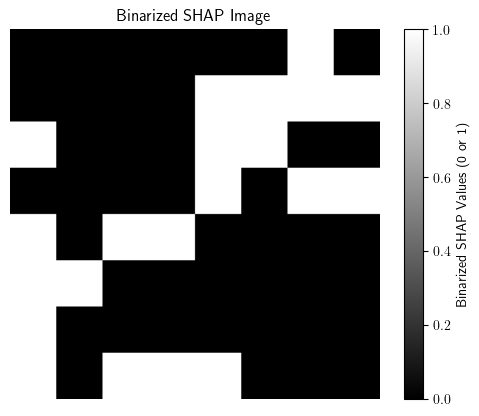

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


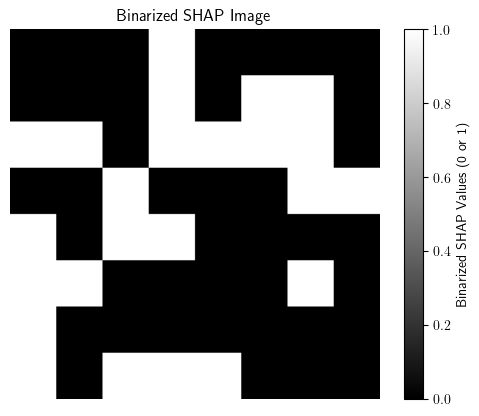

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


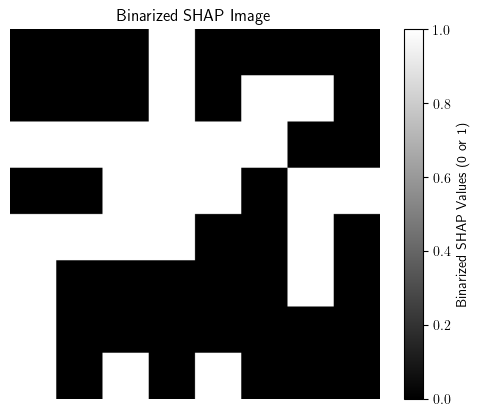

Original SHAP Image Shape             : (224, 224, 3, 1)
Shape after binarization              : (224, 224), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


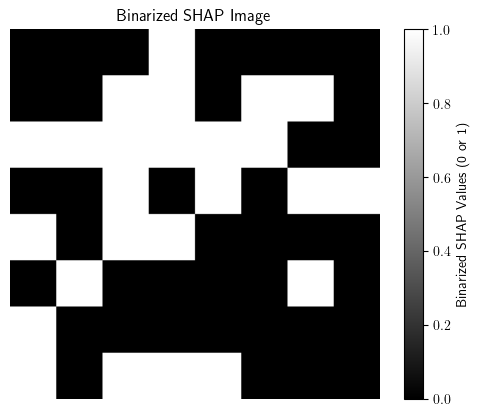

In [202]:
for i, mask in enumerate(shap_diff_seeds):
    shap_img = mask
    visualize_binarized_shap(shap_img)